# Time Series Regression with Neural Networks: Cryptocurrency Price Prediction

In [1]:
!pip install cryptocompare
!nvidia-smi

  Created wheel for cryptocompare: filename=cryptocompare-0.6.4-cp36-none-any.whl size=3612 sha256=060470e1498a0634f1242bd6cd973a515525c86986218f6ce26f1cd680839cc7
  Stored in directory: /root/.cache/pip/wheels/65/a3/15/2a0d81279c399c458d34b33a42d0786d14541efe595ee2fa1c
Successfully built cryptocompare
Fri Aug 16 20:34:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-----------------------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import requests
import os
import yaml
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import urllib3
import cryptocompare
from datetime import datetime
import time

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)

PyTorch version: 1.1.0
NumPy version: 1.16.4


## Data Analysis

                0
0             NaN
1             NaN
2             NaN
3      67269.2175
4      65835.7525
5      62982.2650
6      54837.2475
7      50420.2250
8      50560.2675
9      51495.7825
10     53530.5825
11     54646.8150
12     52664.5975
13     48903.2975
14     44213.2850
15     43554.3975
16     48148.6650
17     50431.5050
18     60174.2650
19     62211.7175
20     54397.5225
21     52531.8200
22     50569.5150
23     49499.9250
24     52056.5175
25     56242.7875
26     52159.4700
27     48661.4800
28     43996.3075
29     46085.3200
...           ...
1411  102438.9400
1412   95002.0800
1413   80809.2625
1414   65146.0950
1415   52178.8325
1416   49618.5050
1417   49114.5575
1418   49591.0950
1419   44937.6675
1420   45019.5175
1421   38410.2100
1422   36197.4200
1423   35421.3900
1424   32658.5375
1425   36456.4275
1426   39651.1000
1427   40962.7850
1428   40404.1150
1429   48214.9700
1430   57335.3750
1431   66533.1175
1432   69052.0950
1433   60172.6675
1434   502

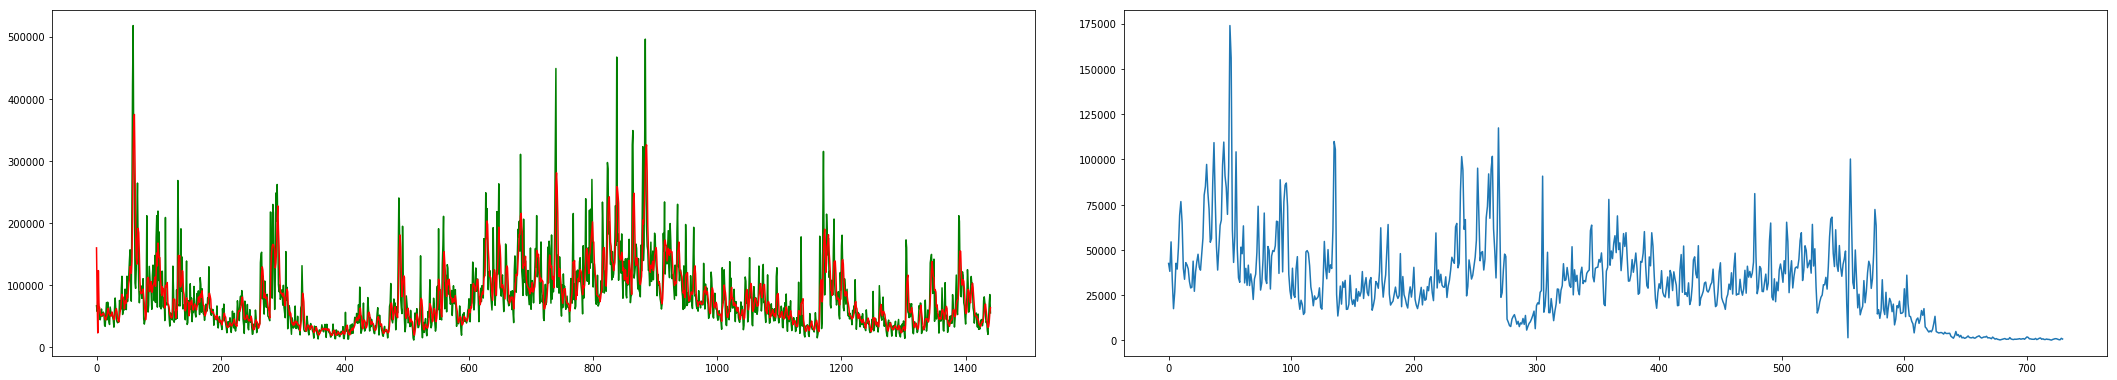

In [17]:
# hourly -- volume -- per day
# USD 

#cryptocompare api key:1 e3c9fe62074dbf5805d45f528d1e60c7ae15be68a63ba57ca3a5f2f9dbbf66f

#close,high,low,open,time,volumefrom,volumeto

def posix2Human(time_):
    timestamp = time_
    dt_object = datetime.fromtimestamp(timestamp)
    return dt_object

histPriceDay = cryptocompare.get_historical_price_day('BTC', curr='USD')

# Getting CryptoCompare BTC volume data -- 2000 API calls back 
vol = []
for idx, item in enumerate(histPriceDay['Data']):
    vol.append(item['volumefrom'])    

# -- Init subplots --
f,arr = plt.subplots(1,2)
  
arr[0].plot(np.array(vol),'g')

# Testing moving average

rolling_amnt = 4
df = pd.DataFrame(vol).rolling(rolling_amnt).mean()
print(df)

min_vol = np.nanmin(df.values)
max_vol = np.nanmax(df.values)

print(min_vol)
print(max_vol)

test = df.values


for i in range(rolling_amnt):
    rand_num = np.random.randint(low=min_vol,high=max_vol)
    test[i] = rand_num

arr[0].plot(test,color='r')
print(arr)

def fetch_latest_BTC_JSON():
    """Fetch the latest JSON data"""
    API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
    page = requests.get(API_LINK).json()
    return page

page = fetch_latest_BTC_JSON()

vol2 = []
for key,value in page['Time Series (Digital Currency Daily)'].items():
    vol2.append(float(value['5. volume']))
    
arr[1].plot(np.array(vol2))

plt.tight_layout()
f.set_figheight(5)
f.set_figwidth(30)

plt.show()



1441
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[20.0, 15.0]


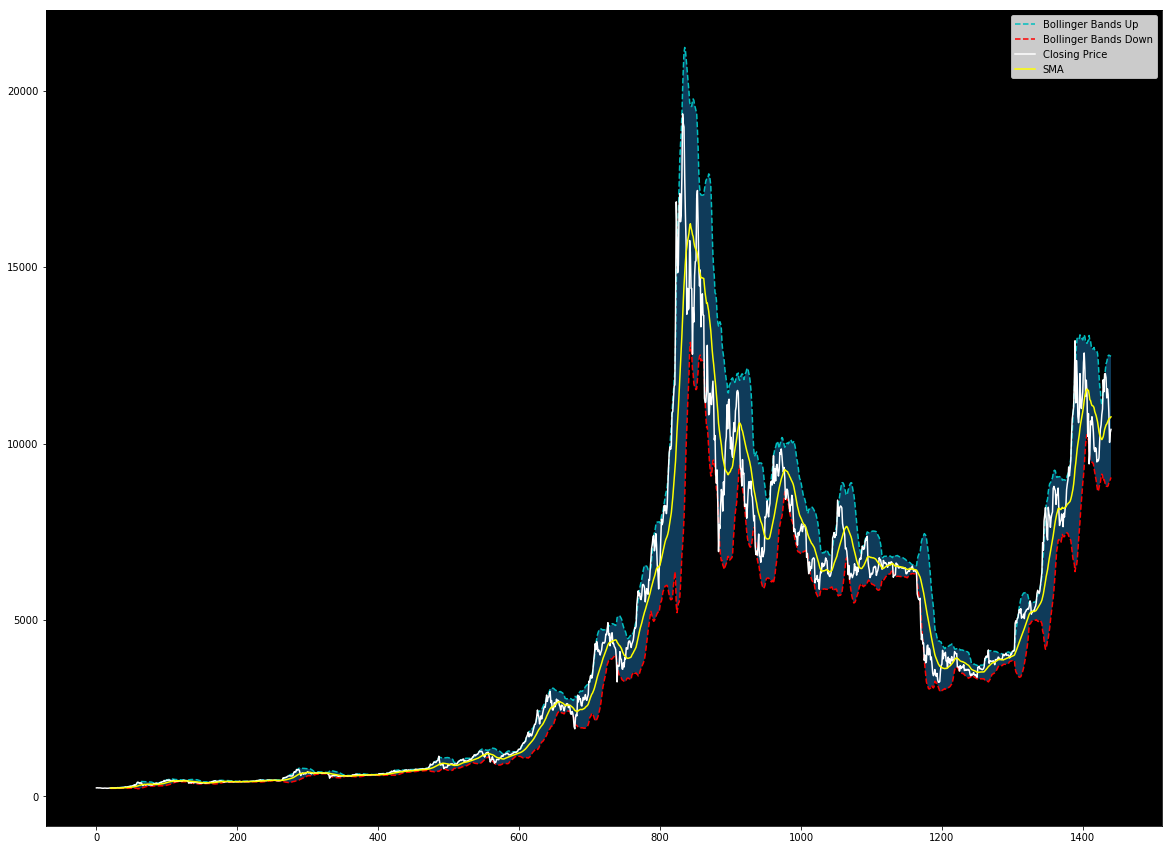

In [18]:
histPriceDay

close_prices = []
for idx,item in enumerate(histPriceDay['Data']):
    close_prices.append(item['close'])

print(len(close_prices))

# Calc SMA
sma = pd.DataFrame(close_prices).rolling(21).sum() / 21

# B-Bands
std = pd.DataFrame(close_prices).rolling(21).std()
lower_band = sma + (std * 2)
upper_band = sma - (std * 2)

print(type(lower_band.values))
print(type(upper_band.values))
lower_band = lower_band.values.flatten()
upper_band = upper_band.values.flatten()

plt.plot(lower_band,'c--')
plt.plot(upper_band,'r--')
x = np.arange(1441)
plt.fill_between(x,np.array(lower_band),np.array(upper_band),interpolate=True,alpha=0.5)
plt.plot(close_prices,'white')
plt.plot(sma,'yellow')
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
fig_size = plt.rcParams["figure.figsize"]
ax = plt.gca()
ax.set_facecolor((0, 0, 0))
plt.legend(['Bollinger Bands Up','Bollinger Bands Down','Closing Price','SMA'])
plt.show()

In [19]:
print('CryptoCompare last reported volume (yesterday): ', vol[-1])

CryptoCompare last reported volume (yesterday):  54786.79


## Config file with Model Hyperparameters

In [66]:
def get_config(file_loc='/content/gdrive/My Drive/College/Undergraduate Research/StockData/config.yaml'):
    return yaml.safe_load(open(file_loc))
config = get_config()
print(type(config))
print(config)

<class 'dict'>
{'model_save_loc': 'models/price_predictor.pt', 'tensorboard_log_loc': '/content/gdrive/My Drive/College/Undergraduate Research/StockData/tensorboard_logs/', 'learning_rate': 0.001, 'batch_size': 1, 'epochs': 500, 'dropout_rate': 0, 'lstm_hidden_size': 1, 'lstm_num_layers': 1, 'scoring_uri': 'http://f8878ff6-dd7c-475c-b4a0-0735e0524948.eastus2.azurecontainer.io/score', 'scoring_uri2': 'http://0a719a6d-cc83-45f0-81c9-f4aa260122aa.eastus2.azurecontainer.io/score'}


## Neural network architectures

* 3 Layer Multi-Layer Perceptron
* 1 Layer Temporal Convolutional Neural Network
* Long-Term-Short-Term Recurrent Neural Network

In [0]:
"""
Basic multilayer perceptron subclass 
of three layers in PyTorch
"""
class MLP(nn.Module):
    def __init__(self,num_features):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=num_features,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

class NumberRegression_MLP(nn.Module):
    def __init__(self):
        super(NumberRegression_MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=1,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
"""
Recurrent Neural Networks (RNN)
RNNs are an excellent method to model sequential data
and time series data. This is perfect for stocks and
crytocurrency price prediction.

https://stackoverflow.com/questions/45022734/understanding-a-simple-lstm-pytorch
https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
"""
class TestRNN(nn.Module):
    def __init__(self,bat_size,in_features,h_size,layer_amnt):
        super(TestRNN,self).__init__()
        
        self.batch_sz = bat_size
        self.in_features = in_features
        self.h_size = h_size
        self.layer_amnt = layer_amnt
        
        self.lstm1 = nn.LSTM(input_size=self.in_features,
                             hidden_size=self.h_size,
                             num_layers=self.layer_amnt,
                             bias=True,
                             batch_first=True,
                             dropout=0,
                             bidirectional=False
                            )
    def init_hidden(self):
        """Intialize/re-init the hidden and cell states. 
        The hidden state acts as the memory of the RNN 
        which gets passed from one unit to another. 
        h_i = f(h_i + in)

        Intializing with 0s
        """
        #print('layer size =\t', self.layer_amnt)
        #print('bat_size =\t', self.batch_sz)
        #print('hidden size =\t',self.h_size)
        return (torch.zeros(self.layer_amnt,self.batch_sz,self.h_size),
                torch.zeros(self.layer_amnt,self.batch_sz,self.h_size))
    def forward(self,x):
        x = x.unsqueeze(0)
        hidden_init = self.init_hidden()
        h0 = hidden_init[0].to(device)
        c0 = hidden_init[1].to(device)
        x,hidden = self.lstm1( x,(h0,c0))
        return x
      
"""
Temporal Convolutional Neural Network (CNN)
Time series based convolutional neural network
"""
class TimeCNN(nn.Module):
    def __init__(self):
        super(TimeCNN,self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=256,kernel_size=2,stride=1,padding=0)
        self.fc1 = nn.Linear(in_features=512,out_features=1024)
        self.fc2 = nn.Linear(in_features=1024,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    def forward(self,x):
        x = x.unsqueeze(0)
        x = F.leaky_relu(self.conv1(x))
        x = x.reshape(-1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

"""
https://arxiv.org/pdf/1506.00019.pdf
https://www.quora.com/How-is-the-hidden-state-h-different-from-the-memory-c-in-an-LSTM-cell
"""
class TimeRNN(nn.Module):
    def __init__(self,bat_size,in_features,h_size,layer_amnt):
        super(TimeRNN,self).__init__()
        
        self.batch_sz = bat_size
        self.in_features = in_features
        self.h_size = h_size
        self.layer_amnt = layer_amnt
        
        self.lstm1 = nn.LSTM(input_size=self.in_features,
                             hidden_size=self.h_size,
                             num_layers=self.layer_amnt,
                             bias=True,
                             batch_first=True,
                             dropout=0,
                             bidirectional=False)
        self.fc1 = nn.Linear(in_features=1,out_features=1)
    def init_hidden(self):
        """Intialize/re-init the hidden and cell states. 
        The hidden state acts as the memory of the RNN 
        which gets passed from one unit to another. 
        h_i = f(h_i + in)

        Intializing with 0s
        """
        #print('layer size =\t', self.layer_amnt)
        #print('bat_size =\t', self.batch_sz)
        #print('hidden size =\t',self.h_size)
        return (torch.zeros(self.layer_amnt,self.batch_sz,self.h_size),
                torch.zeros(self.layer_amnt,self.batch_sz,self.h_size))
    def forward(self,x):
        x = x.unsqueeze(0)
        hidden_init = self.init_hidden()
        h0 = hidden_init[0].to(device)
        c0 = hidden_init[1].to(device)
        x,hidden = self.lstm1( x,(h0,c0))
        x = F.leaky_relu(self.fc1(x[-1].view(self.batch_sz,-1)))
        return x

In [0]:
class TickerData(torch.utils.data.Dataset):
    def __init__(self, table):
        self.dataset = table
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        """idx --> data pointer"""
        return self.dataset[idx]

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device state:\t", device)
print("Device index:\t",torch.cuda.current_device())
print("Current device:\t", torch.cuda.get_device_name(device))

Device state:	 cuda
Device index:	 0
Current device:	 Tesla T4


In [0]:
writer = SummaryWriter(log_dir=config['tensorboard_log_loc'])

## Data Prep

In [0]:
class DataPrepper():
    def __init__(self):
        self.raw_data = self.fetch_latest_BTC_JSON()
        self.dataframe = self.parse_alphaV_JSON(raw_data=self.raw_data)
        self.dataframe = self.dataframe.iloc[::-1] # Flip data
        self.prices = np.array(self.dataframe['4a. close (USD)'].tolist())

        # Temporary dataframe for creating an extra normalizer for re-scaling inference values later
        data_df_temp = self.dataframe.drop(labels=['1a. open (USD)','1b. open (USD)','2b. high (USD)','3b. low (USD)','4a. close (USD)','4b. close (USD)','6. market cap (USD)'],axis=1)
        self.minmax_2 = MinMaxScaler(data=data_df_temp.values)
        data_df_temp = pd.DataFrame(self.minmax_2.fit_transform(), columns=data_df_temp.columns)
        
        # -- Normalize the Data --
        self.min_max_scaler = MinMaxScaler(data=self.dataframe.values)
        self.dataframe = pd.DataFrame(self.min_max_scaler.fit_transform(), columns=self.dataframe.columns)
        self.dataframe = self.table_edit(self.dataframe)
        self.targets = np.array(self.dataframe['4a. close (USD)'].tolist())
        self.dataframe = self.dataframe.drop(labels=['4a. close (USD)'],axis=1)
        
        self.dataframe = self.dataframe.drop(labels=['1a. open (USD)','6. market cap (USD)'],axis=1)

    def get_data(self):
        """Returns x-data and y-data"""
        return self.dataframe.values,self.targets
    
    def fetch_latest_BTC_JSON(self):
        """Fetch the latest JSON data"""
        API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
        page = requests.get(API_LINK).json()
        return page
    def fetch_btc_prices(self):
        with open("/content/gdrive/My Drive/College/Undergraduate Research/StockData/BTC_data.json") as f:
            return json.load(f)  

    def parse_alphaV_JSON(self,raw_data):
        # Remove meta data for now
        raw_data.pop('Meta Data',None)
        # Remove key name
        df = pd.DataFrame.from_dict(raw_data['Time Series (Digital Currency Daily)'],dtype=float)
        # Flip dates as columns into rows
        df = df.transpose()
        return df
    
    def table_edit(self,dataframe):
        dataframe = dataframe.drop(labels=['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
        table_col_order = ['1a. open (USD)','2a. high (USD)','3a. low (USD)','5. volume','6. market cap (USD)','4a. close (USD)']
        dataframe = dataframe[table_col_order]
        return dataframe

In [0]:
class Feature:
    def __init__(self,data):
        self.data = data
        self.feat_max = self.calc_max()
        self.feat_min = self.calc_min()
    def calc_max(self):
        return np.max(self.data)
    def calc_min(self):
        return np.min(self.data)

class MinMaxScaler:
    def __init__(self,data):
        self.data = data
        self.original_data = data
        self.feature_col = []
    def normalize(self,val,min_val,max_val):
        return (val-min_val)/(max_val-min_val)
    def inverse_normalize(self,val,min_val,max_val):
        return val * (max_val - min_val) + min_val
    def fit_transform(self):
        for column in self.data.T:
            feat = Feature(column)
            self.feature_col.append(feat)
            for idx,value in enumerate(column):
                #print(value)
                column[idx] = self.normalize(val=value,min_val=feat.feat_min,max_val=feat.feat_max)
            #print()
        return self.data
    def transform(self,val):
        for idx,(value,feature_col) in enumerate(zip(val.T,self.feature_col)):
            transform_val = self.normalize(val=value,min_val=feature_col.feat_min,max_val=feature_col.feat_max)
            val.T[idx] = transform_val
        return val
    def inverse_transform(self,val):
        typelist=True
        val = np.array(val)
        if(typelist):
            for idx,(value,feature_col) in enumerate(zip(val.T,self.feature_col)):
                #print(value)
                #print(feature_col.feat_max)
                transform_val = self.inverse_normalize(val=value,min_val=feature_col.feat_min,max_val=feature_col.feat_max)
                val.T[idx] = transform_val
                #val[idx] = new_val
            return val
        else:
            return val * (max_val - min_val) + min_val 
    
    def inverse_transform_by_column(self,val,col_num):
        for idx,(value,feature_col) in enumerate(zip(val.T,self.feature_col)):
                #print(value)
                #print(feature_col.feat_max)
                transform_val = self.inverse_normalize(val=value,min_val=feature_col.feat_min,max_val=feature_col.feat_max)
                val.T[idx] = transform_val
                #val[idx] = new_val
        return val

def train_test_split(x_data,y_data,test_size):
    if(len(x_data) == len(y_data)):
        train_size = 1.0 - test_size
        train_idx = int(len(x_data)*train_size)
        x_train = x_data[:train_idx]
        x_test = x_data[train_idx:]
        y_train = y_data[:train_idx]
        y_test = y_data[train_idx:]
        return x_train,x_test,y_train,y_test
    else:
        raise Exception("x-data and y-data are of different sizes!")

## Training Phase

In [0]:
class Trainer(object):
    def __init__(self,DataPrepper=None):
        self.dataprepper = DataPrepper
        self.x_data,self.y_data = self.dataprepper.get_data()
        self.x_train,self.x_test,self.y_train,self.y_test = self.data_split(x_data=self.x_data,
                                                                            y_data=self.y_data)
        
        self.unnorm_y_test = self.dataprepper.min_max_scaler.inverse_transform(self.y_test.reshape(self.y_test.shape[0],1))
        print("unnormed = ",self.unnorm_y_test)
        self.train_dataloader, self.test_dataloader = self.create_dataloaders(self.x_data,
                                                                              self.y_data)
    def create_dataloaders(self,x_data,y_data):
        """splits data tensor into test and train sets
        and creates dataloaders for training"""
        x_train, x_test, y_train, y_test = self.data_split(x_data,y_data)
        train_tensorDataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
        train_data_loader = torch.utils.data.DataLoader(
            dataset=train_tensorDataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=0
        )
        test_tensorDataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
        test_data_loader = torch.utils.data.DataLoader(
            dataset=test_tensorDataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=0
        )
        return train_data_loader, test_data_loader

    def data_split(self,x_data,y_data):
        x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2)
        return x_train, x_test, y_train, y_test

    def train(self,model, train_data, original_prices,epochs):
        """Price prediction model training loop function. This method
        is generalized for the purposes of allowing any model to be used.

        Arguments:
            * model - torch subclassed model
            * x_data - input tensor dataset
            * y_data - targer tensor dataset
            * original_prices - original target dataset for re-scaling
            * epochs - number of epochs for training
        Returns:
            * losses
            * test_data_loader
            * loss_func
            * model 
            * min_price
            * max_price
            * y_test
        """
        prices = torch.tensor(original_prices)
        self.max_price = torch.max(prices)
        self.min_price = torch.min(prices)

        print('-- Model Architecture --')
        self.model = model
        print(self.model)

        # -- Model to CUDA GPU --
        if( str(device) == 'cuda'):
            print('Sending model to',torch.cuda.get_device_name(device),' GPU')
            #model = model.cuda()
            model.to(device)

        self.loss_func = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        total_loss = 0
        losses = []
        for epoch in (range(epochs)):
            for i, (examples,labels) in tqdm(enumerate(train_data)):

                if( str(device) == 'cuda'):
                    examples = examples.to(device)
                    labels = labels.to(device)

                optimizer.zero_grad()

                y_predictions = model(examples.float())
                loss = self.loss_func(y_predictions.float(),labels.float())

                writer.add_scalar(tag='loss_by_epoch',scalar_value=loss.data,global_step=epoch)
                writer.add_scalar(tag='loss_by_batch',scalar_value=loss.data,global_step=i)

                total_loss += loss.data

                # back-prop to update the weights
                loss.backward()
                # optimizer steps based on lr
                optimizer.step()

                y_preds = y_predictions.cpu().detach().numpy()
                y_preds = torch.tensor(y_preds)
                #print(y_preds.shape)
                test = self.un_normalize(y_preds, self.min_price, self.max_price)
                #print("---> ", test)
                #break

            print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, config['epochs'], loss.data))
            #print(list(model.parameters()))
            print("-----------------------------------------------------------------------------")
            losses.append(loss.data)
        writer.close()
        return losses, self.loss_func, self.model, self.min_price, self.max_price

    def loss_visualize(self,loss_tensor):
        losses = np.array(loss_tensor)
        print(losses)

        plt.plot(losses)

    def validation_test(self,test_dataloader, criterion, model, norm_min, norm_max):
        test_loss = 0
        accuracy = 0
        all_predictions = []
        for (examples, labels) in test_dataloader:

            if(str(device) == 'cuda'):
                examples = examples.to(device)
                labels = labels.to(device)

            output = model.forward(examples)

            un_normed_outputs = self.un_normalize(output, norm_min,norm_max)
            all_predictions.append(un_normed_outputs.detach())
            loss = criterion(output, labels.view(1,1)).item()
            test_loss += loss
        
        self.unnorm_predictions = all_predictions
        return test_loss, accuracy, all_predictions

    def un_normalize(self,norm_val,min_val,max_val,typelist=None):
        if(typelist):
            for idx,item in enumerate(norm_val):
                new_val = item * (max_val - min_val) + min_val
                norm_val[idx] = new_val
            return norm_val
        else:
            return norm_val * (max_val - min_val) + min_val  

    def prediction_visualization(self,DEBUG=False,minimum_price=[],maximum_price=[],close_prices=[],model_predictions=[]):
        plt.close()
        fig,ax = plt.subplots(figsize=(10,10))
        test_values = np.array(self.un_normalize(norm_val=close_prices,min_val=minimum_price,max_val=maximum_price,typelist=True))
        #print(test_values)
        #print(np.array(model_predictions.grad))
        #model_predictions[0].requires_grad = False
        #print(model_predictions) ###
        #print(len(model_predictions))
        for idx,item in enumerate(model_predictions):
            if(DEBUG):
                print('the item is =\t',item)
                print('the size of the item is =\t', item.shape)
            if (type(item) is float):
                model_predictions[idx] = item
            else:
                model_predictions[idx] = np.asscalar(item.cpu().numpy())
        predicted_values = model_predictions

        if(DEBUG):
            print(len(test_values))
            print(len(predicted_values))

        
        start = min( np.min(test_values),np.min(predicted_values))
        end = max(( np.max(test_values),np.max(predicted_values)))

        #print(start)
        #print(end)
        
        

        plt.yticks(np.arange(start-100,end+100,400))
        #plt.yaxis.tick_right()
        ax.tick_params(axis='y', which='both', labelleft='off', labelright='on')
        ax.grid()
        ax.plot(np.array(test_values),color='#FFA500')
        ax.plot(np.array(predicted_values),color='g')
        ax.legend(['Actual Value','Predicted Value'],prop={'size': 15})
        an1 = ax.annotate('Curr: '+str(int(predicted_values[-1])), xy=(len(predicted_values) -1,predicted_values[-1]), xycoords='data',
                   ha="center", va="center",
                   )
        an1 = ax.annotate('Curr: '+str(int(test_values[-1])), xy=(len(test_values) -1,test_values[-1]), xycoords='data',
                   ha="center", va="center",
                   )
        plt.show()
        pass

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
33it [00:00, 329.41it/s]

unnormed =  [[ 3992.10571216]
 [ 3935.98040011]
 [ 3948.42488154]
 [ 4038.02915246]
 [ 4027.77722247]
 [ 4103.30511296]
 [ 4107.0294469 ]
 [ 4104.00592849]
 [ 4144.66324069]
 [ 4858.22359844]
 [ 4933.62133747]
 [ 4899.64179607]
 [ 5006.05562799]
 [ 5045.04099458]
 [ 5171.56823212]
 [ 5238.27585862]
 [ 5151.27461679]
 [ 5309.7089841 ]
 [ 5018.49009777]
 [ 5049.16579454]
 [ 5046.37254408]
 [ 5132.55283058]
 [ 5026.07892876]
 [ 5175.0222515 ]
 [ 5204.15615412]
 [ 5259.84095355]
 [ 5260.08123316]
 [ 5293.16973767]
 [ 5257.53827396]
 [ 5358.65594283]
 [ 5494.98458609]
 [ 5416.58335194]
 [ 5221.25605297]
 [ 5315.56579958]
 [ 5297.13435122]
 [ 5308.97813363]
 [ 5239.51730327]
 [ 5322.28361699]
 [ 5384.74630372]
 [ 5494.54407347]
 [ 5774.69007449]
 [ 5831.51620206]
 [ 5777.62348805]
 [ 5749.76106504]
 [ 5848.42587956]
 [ 5989.54009171]
 [ 6211.68860205]
 [ 6376.02984309]
 [ 7079.73873686]
 [ 6970.70185254]
 [ 7795.06114507]
 [ 7952.09388132]
 [ 8174.66288099]
 [ 7871.02954817]
 [ 7359.10382914

584it [00:01, 339.34it/s]
35it [00:00, 344.07it/s]

Epoch [1/500], Loss: 0.00018145699868910015
-----------------------------------------------------------------------------


584it [00:01, 359.82it/s]
40it [00:00, 391.64it/s]

Epoch [2/500], Loss: 0.0004889756673946977
-----------------------------------------------------------------------------


584it [00:01, 380.15it/s]
38it [00:00, 372.17it/s]

Epoch [3/500], Loss: 0.00026343061472289264
-----------------------------------------------------------------------------


584it [00:01, 366.64it/s]
38it [00:00, 377.45it/s]

Epoch [4/500], Loss: 0.0001254540984518826
-----------------------------------------------------------------------------


584it [00:01, 372.07it/s]
38it [00:00, 379.51it/s]

Epoch [5/500], Loss: 5.2711744501721114e-05
-----------------------------------------------------------------------------


584it [00:01, 375.25it/s]
38it [00:00, 372.22it/s]

Epoch [6/500], Loss: 1.9317471014801413e-05
-----------------------------------------------------------------------------


584it [00:01, 372.90it/s]
36it [00:00, 356.58it/s]

Epoch [7/500], Loss: 7.584695595141966e-06
-----------------------------------------------------------------------------


584it [00:01, 366.07it/s]
36it [00:00, 357.84it/s]

Epoch [8/500], Loss: 5.600489657808794e-06
-----------------------------------------------------------------------------


584it [00:01, 358.24it/s]
32it [00:00, 316.34it/s]

Epoch [9/500], Loss: 7.898536750872154e-06
-----------------------------------------------------------------------------


584it [00:01, 339.17it/s]
34it [00:00, 339.45it/s]

Epoch [10/500], Loss: 1.271705150429625e-05
-----------------------------------------------------------------------------


584it [00:01, 348.26it/s]
35it [00:00, 348.70it/s]

Epoch [11/500], Loss: 1.8494278265279718e-05
-----------------------------------------------------------------------------


584it [00:01, 348.55it/s]
35it [00:00, 344.41it/s]

Epoch [12/500], Loss: 2.3806582248653285e-05
-----------------------------------------------------------------------------


584it [00:01, 347.26it/s]
36it [00:00, 351.81it/s]

Epoch [13/500], Loss: 2.781976763799321e-05
-----------------------------------------------------------------------------


584it [00:01, 340.94it/s]
36it [00:00, 359.92it/s]

Epoch [14/500], Loss: 3.0420133043662645e-05
-----------------------------------------------------------------------------


584it [00:01, 351.81it/s]
34it [00:00, 337.46it/s]

Epoch [15/500], Loss: 3.170106720062904e-05
-----------------------------------------------------------------------------


584it [00:01, 371.09it/s]
37it [00:00, 360.30it/s]

Epoch [16/500], Loss: 3.203827145625837e-05
-----------------------------------------------------------------------------


584it [00:01, 362.31it/s]
39it [00:00, 380.46it/s]

Epoch [17/500], Loss: 3.176414975314401e-05
-----------------------------------------------------------------------------


584it [00:01, 369.29it/s]
38it [00:00, 370.99it/s]

Epoch [18/500], Loss: 3.111753539997153e-05
-----------------------------------------------------------------------------


584it [00:01, 362.88it/s]
37it [00:00, 364.19it/s]

Epoch [19/500], Loss: 3.02713942801347e-05
-----------------------------------------------------------------------------


584it [00:01, 364.80it/s]
37it [00:00, 362.99it/s]

Epoch [20/500], Loss: 2.928713547589723e-05
-----------------------------------------------------------------------------


584it [00:01, 360.11it/s]
35it [00:00, 346.57it/s]

Epoch [21/500], Loss: 2.8272535928408615e-05
-----------------------------------------------------------------------------


584it [00:01, 365.96it/s]
34it [00:00, 339.88it/s]

Epoch [22/500], Loss: 2.723564102780074e-05
-----------------------------------------------------------------------------


584it [00:01, 365.22it/s]
38it [00:00, 375.20it/s]

Epoch [23/500], Loss: 2.619138285808731e-05
-----------------------------------------------------------------------------


584it [00:01, 366.80it/s]
38it [00:00, 376.44it/s]

Epoch [24/500], Loss: 2.5142684535239823e-05
-----------------------------------------------------------------------------


584it [00:01, 374.17it/s]
38it [00:00, 374.35it/s]

Epoch [25/500], Loss: 2.4100048904074356e-05
-----------------------------------------------------------------------------


584it [00:01, 371.25it/s]
38it [00:00, 375.11it/s]

Epoch [26/500], Loss: 2.3064747438183986e-05
-----------------------------------------------------------------------------


584it [00:01, 368.79it/s]
38it [00:00, 376.97it/s]

Epoch [27/500], Loss: 2.2042484488338232e-05
-----------------------------------------------------------------------------


584it [00:01, 371.07it/s]
38it [00:00, 374.50it/s]

Epoch [28/500], Loss: 2.103805854858365e-05
-----------------------------------------------------------------------------


584it [00:01, 368.91it/s]
38it [00:00, 373.32it/s]

Epoch [29/500], Loss: 2.005191709031351e-05
-----------------------------------------------------------------------------


584it [00:01, 377.38it/s]
39it [00:00, 389.36it/s]

Epoch [30/500], Loss: 1.9088794942945242e-05
-----------------------------------------------------------------------------


584it [00:01, 381.13it/s]
38it [00:00, 372.68it/s]

Epoch [31/500], Loss: 1.814940696931444e-05
-----------------------------------------------------------------------------


584it [00:01, 371.97it/s]
38it [00:00, 378.27it/s]

Epoch [32/500], Loss: 1.7236134226550348e-05
-----------------------------------------------------------------------------


584it [00:01, 375.08it/s]
35it [00:00, 349.76it/s]

Epoch [33/500], Loss: 1.6350109945051372e-05
-----------------------------------------------------------------------------


584it [00:01, 368.06it/s]
39it [00:00, 381.13it/s]

Epoch [34/500], Loss: 1.5491803424083628e-05
-----------------------------------------------------------------------------


584it [00:01, 371.31it/s]
36it [00:00, 359.31it/s]

Epoch [35/500], Loss: 1.4661316527053714e-05
-----------------------------------------------------------------------------


584it [00:01, 371.61it/s]
39it [00:00, 389.65it/s]

Epoch [36/500], Loss: 1.3859558748663403e-05
-----------------------------------------------------------------------------


584it [00:01, 373.44it/s]
36it [00:00, 351.08it/s]

Epoch [37/500], Loss: 1.308761966356542e-05
-----------------------------------------------------------------------------


584it [00:01, 371.72it/s]
39it [00:00, 384.22it/s]

Epoch [38/500], Loss: 1.2344735296210274e-05
-----------------------------------------------------------------------------


584it [00:01, 373.13it/s]
38it [00:00, 379.79it/s]

Epoch [39/500], Loss: 1.163036358775571e-05
-----------------------------------------------------------------------------


584it [00:01, 376.54it/s]
40it [00:00, 391.74it/s]

Epoch [40/500], Loss: 1.0945267604256514e-05
-----------------------------------------------------------------------------


584it [00:01, 375.36it/s]
39it [00:00, 383.39it/s]

Epoch [41/500], Loss: 1.0289759302395396e-05
-----------------------------------------------------------------------------


584it [00:01, 377.45it/s]
38it [00:00, 374.74it/s]

Epoch [42/500], Loss: 9.661877811595332e-06
-----------------------------------------------------------------------------


584it [00:01, 377.62it/s]
38it [00:00, 378.69it/s]

Epoch [43/500], Loss: 9.062416211236268e-06
-----------------------------------------------------------------------------


584it [00:01, 376.56it/s]
40it [00:00, 395.51it/s]

Epoch [44/500], Loss: 8.490811524097808e-06
-----------------------------------------------------------------------------


584it [00:01, 375.97it/s]
38it [00:00, 371.62it/s]

Epoch [45/500], Loss: 7.946518053358886e-06
-----------------------------------------------------------------------------


584it [00:01, 374.19it/s]
39it [00:00, 384.74it/s]

Epoch [46/500], Loss: 7.428536264342256e-06
-----------------------------------------------------------------------------


584it [00:01, 370.86it/s]
38it [00:00, 377.14it/s]

Epoch [47/500], Loss: 6.936366844456643e-06
-----------------------------------------------------------------------------


584it [00:01, 379.26it/s]
38it [00:00, 375.83it/s]

Epoch [48/500], Loss: 6.469779236795148e-06
-----------------------------------------------------------------------------


584it [00:01, 373.88it/s]
39it [00:00, 381.44it/s]

Epoch [49/500], Loss: 6.027444669598481e-06
-----------------------------------------------------------------------------


584it [00:01, 377.24it/s]
36it [00:00, 352.29it/s]

Epoch [50/500], Loss: 5.608568244497292e-06
-----------------------------------------------------------------------------


584it [00:01, 375.67it/s]
38it [00:00, 370.89it/s]

Epoch [51/500], Loss: 5.212562882661587e-06
-----------------------------------------------------------------------------


584it [00:01, 379.92it/s]
38it [00:00, 371.42it/s]

Epoch [52/500], Loss: 4.838901986659039e-06
-----------------------------------------------------------------------------


584it [00:01, 376.64it/s]
38it [00:00, 374.63it/s]

Epoch [53/500], Loss: 4.4862190407002345e-06
-----------------------------------------------------------------------------


584it [00:01, 378.90it/s]
38it [00:00, 372.54it/s]

Epoch [54/500], Loss: 4.153300324105658e-06
-----------------------------------------------------------------------------


584it [00:01, 374.52it/s]
39it [00:00, 383.64it/s]

Epoch [55/500], Loss: 3.840935733023798e-06
-----------------------------------------------------------------------------


584it [00:01, 375.06it/s]
37it [00:00, 365.20it/s]

Epoch [56/500], Loss: 3.5463349377096165e-06
-----------------------------------------------------------------------------


584it [00:01, 375.83it/s]
38it [00:00, 376.62it/s]

Epoch [57/500], Loss: 3.270247589171049e-06
-----------------------------------------------------------------------------


584it [00:01, 377.93it/s]
35it [00:00, 345.25it/s]

Epoch [58/500], Loss: 3.010800128322444e-06
-----------------------------------------------------------------------------


584it [00:01, 371.38it/s]
39it [00:00, 384.78it/s]

Epoch [59/500], Loss: 2.7680951006914256e-06
-----------------------------------------------------------------------------


584it [00:01, 375.13it/s]
38it [00:00, 375.38it/s]

Epoch [60/500], Loss: 2.540122068239725e-06
-----------------------------------------------------------------------------


584it [00:01, 376.94it/s]
39it [00:00, 382.73it/s]

Epoch [61/500], Loss: 2.3274765226233285e-06
-----------------------------------------------------------------------------


584it [00:01, 373.63it/s]
39it [00:00, 383.34it/s]

Epoch [62/500], Loss: 2.1290579752530903e-06
-----------------------------------------------------------------------------


584it [00:01, 375.75it/s]
39it [00:00, 380.71it/s]

Epoch [63/500], Loss: 1.9434746718616225e-06
-----------------------------------------------------------------------------


584it [00:01, 378.69it/s]
39it [00:00, 384.31it/s]

Epoch [64/500], Loss: 1.7705438040138688e-06
-----------------------------------------------------------------------------


584it [00:01, 379.23it/s]
37it [00:00, 367.95it/s]

Epoch [65/500], Loss: 1.609844844097097e-06
-----------------------------------------------------------------------------


584it [00:01, 370.35it/s]
38it [00:00, 375.93it/s]

Epoch [66/500], Loss: 1.46003787904192e-06
-----------------------------------------------------------------------------


584it [00:01, 374.80it/s]
39it [00:00, 386.64it/s]

Epoch [67/500], Loss: 1.3215510534791974e-06
-----------------------------------------------------------------------------


584it [00:01, 371.58it/s]
38it [00:00, 375.44it/s]

Epoch [68/500], Loss: 1.1928096910196473e-06
-----------------------------------------------------------------------------


584it [00:01, 373.58it/s]
38it [00:00, 378.72it/s]

Epoch [69/500], Loss: 1.0737504680946586e-06
-----------------------------------------------------------------------------


584it [00:01, 372.21it/s]
39it [00:00, 385.32it/s]

Epoch [70/500], Loss: 9.636172535465448e-07
-----------------------------------------------------------------------------


584it [00:01, 370.46it/s]
39it [00:00, 383.38it/s]

Epoch [71/500], Loss: 8.621100278105587e-07
-----------------------------------------------------------------------------


584it [00:01, 371.10it/s]
38it [00:00, 378.08it/s]

Epoch [72/500], Loss: 7.686919616389787e-07
-----------------------------------------------------------------------------


584it [00:01, 367.27it/s]
35it [00:00, 341.22it/s]

Epoch [73/500], Loss: 6.827703487033432e-07
-----------------------------------------------------------------------------


584it [00:01, 370.61it/s]
39it [00:00, 387.47it/s]

Epoch [74/500], Loss: 6.040627908987517e-07
-----------------------------------------------------------------------------


584it [00:01, 374.86it/s]
38it [00:00, 375.44it/s]

Epoch [75/500], Loss: 5.318405555954087e-07
-----------------------------------------------------------------------------


584it [00:01, 378.77it/s]
39it [00:00, 386.13it/s]

Epoch [76/500], Loss: 4.660391823563259e-07
-----------------------------------------------------------------------------


584it [00:01, 375.79it/s]
39it [00:00, 387.02it/s]

Epoch [77/500], Loss: 4.0613744545225927e-07
-----------------------------------------------------------------------------


584it [00:01, 374.09it/s]
39it [00:00, 385.43it/s]

Epoch [78/500], Loss: 3.51855703684123e-07
-----------------------------------------------------------------------------


584it [00:01, 378.05it/s]
40it [00:00, 391.00it/s]

Epoch [79/500], Loss: 3.026331967248552e-07
-----------------------------------------------------------------------------


584it [00:01, 385.32it/s]
38it [00:00, 378.51it/s]

Epoch [80/500], Loss: 2.584418155038293e-07
-----------------------------------------------------------------------------


584it [00:01, 374.52it/s]
38it [00:00, 374.86it/s]

Epoch [81/500], Loss: 2.1869358590720367e-07
-----------------------------------------------------------------------------


584it [00:01, 380.17it/s]
39it [00:00, 385.30it/s]

Epoch [82/500], Loss: 1.8317960837066494e-07
-----------------------------------------------------------------------------


584it [00:01, 378.41it/s]
39it [00:00, 385.36it/s]

Epoch [83/500], Loss: 1.516069261242592e-07
-----------------------------------------------------------------------------


584it [00:01, 383.43it/s]
37it [00:00, 369.98it/s]

Epoch [84/500], Loss: 1.237905138395945e-07
-----------------------------------------------------------------------------


584it [00:01, 375.83it/s]
39it [00:00, 387.32it/s]

Epoch [85/500], Loss: 9.949233259476387e-08
-----------------------------------------------------------------------------


584it [00:01, 379.85it/s]
39it [00:00, 384.55it/s]

Epoch [86/500], Loss: 7.836677440309359e-08
-----------------------------------------------------------------------------


584it [00:01, 380.05it/s]
37it [00:00, 367.08it/s]

Epoch [87/500], Loss: 6.023567777901917e-08
-----------------------------------------------------------------------------


584it [00:01, 376.38it/s]
38it [00:00, 374.24it/s]

Epoch [88/500], Loss: 4.48992842905227e-08
-----------------------------------------------------------------------------


584it [00:01, 374.75it/s]
40it [00:00, 391.53it/s]

Epoch [89/500], Loss: 3.2182594367213824e-08
-----------------------------------------------------------------------------


584it [00:01, 377.21it/s]
39it [00:00, 381.69it/s]

Epoch [90/500], Loss: 2.1815381501255615e-08
-----------------------------------------------------------------------------


584it [00:01, 373.50it/s]
36it [00:00, 358.55it/s]

Epoch [91/500], Loss: 1.3673358445487338e-08
-----------------------------------------------------------------------------


584it [00:01, 372.92it/s]
40it [00:00, 399.52it/s]

Epoch [92/500], Loss: 7.558707437738121e-09
-----------------------------------------------------------------------------


584it [00:01, 379.90it/s]
40it [00:00, 389.24it/s]

Epoch [93/500], Loss: 3.34404082202866e-09
-----------------------------------------------------------------------------


584it [00:01, 381.14it/s]
39it [00:00, 388.88it/s]

Epoch [94/500], Loss: 8.762284786634211e-10
-----------------------------------------------------------------------------


584it [00:01, 379.01it/s]
37it [00:00, 367.52it/s]

Epoch [95/500], Loss: 4.668487818548783e-12
-----------------------------------------------------------------------------


584it [00:01, 379.33it/s]
38it [00:00, 377.86it/s]

Epoch [96/500], Loss: 6.004930441783074e-10
-----------------------------------------------------------------------------


584it [00:01, 379.39it/s]
39it [00:00, 383.24it/s]

Epoch [97/500], Loss: 2.544988664254788e-09
-----------------------------------------------------------------------------


584it [00:01, 379.74it/s]
39it [00:00, 388.63it/s]

Epoch [98/500], Loss: 5.708760131284407e-09
-----------------------------------------------------------------------------


584it [00:01, 381.29it/s]
38it [00:00, 375.14it/s]

Epoch [99/500], Loss: 9.995869021395265e-09
-----------------------------------------------------------------------------


584it [00:01, 379.31it/s]
39it [00:00, 386.08it/s]

Epoch [100/500], Loss: 1.5288360799559086e-08
-----------------------------------------------------------------------------


584it [00:01, 382.36it/s]
39it [00:00, 385.08it/s]

Epoch [101/500], Loss: 2.1495232260804187e-08
-----------------------------------------------------------------------------


584it [00:01, 383.80it/s]
39it [00:00, 389.94it/s]

Epoch [102/500], Loss: 2.854011249553423e-08
-----------------------------------------------------------------------------


584it [00:01, 377.66it/s]
38it [00:00, 371.93it/s]

Epoch [103/500], Loss: 3.632154843558055e-08
-----------------------------------------------------------------------------


584it [00:01, 384.37it/s]
38it [00:00, 376.68it/s]

Epoch [104/500], Loss: 4.47746515419567e-08
-----------------------------------------------------------------------------


584it [00:01, 380.19it/s]
39it [00:00, 383.33it/s]

Epoch [105/500], Loss: 5.3784205533702334e-08
-----------------------------------------------------------------------------


584it [00:01, 378.56it/s]
39it [00:00, 384.13it/s]

Epoch [106/500], Loss: 6.336188107525231e-08
-----------------------------------------------------------------------------


584it [00:01, 373.72it/s]
39it [00:00, 385.31it/s]

Epoch [107/500], Loss: 7.337638407989289e-08
-----------------------------------------------------------------------------


584it [00:01, 379.13it/s]
38it [00:00, 375.70it/s]

Epoch [108/500], Loss: 8.378422933219554e-08
-----------------------------------------------------------------------------


584it [00:01, 380.89it/s]
39it [00:00, 383.31it/s]

Epoch [109/500], Loss: 9.451981952679489e-08
-----------------------------------------------------------------------------


584it [00:01, 385.14it/s]
38it [00:00, 379.80it/s]

Epoch [110/500], Loss: 1.0554867913015187e-07
-----------------------------------------------------------------------------


584it [00:01, 384.79it/s]
37it [00:00, 368.18it/s]

Epoch [111/500], Loss: 1.1681134992613806e-07
-----------------------------------------------------------------------------


584it [00:01, 382.61it/s]
39it [00:00, 389.86it/s]

Epoch [112/500], Loss: 1.2823630868297187e-07
-----------------------------------------------------------------------------


584it [00:01, 389.58it/s]
41it [00:00, 404.28it/s]

Epoch [113/500], Loss: 1.3986523583753296e-07
-----------------------------------------------------------------------------


584it [00:01, 390.71it/s]
40it [00:00, 399.80it/s]

Epoch [114/500], Loss: 1.5158661881287117e-07
-----------------------------------------------------------------------------


584it [00:01, 387.82it/s]
40it [00:00, 391.74it/s]

Epoch [115/500], Loss: 1.6342097808319522e-07
-----------------------------------------------------------------------------


584it [00:01, 386.04it/s]
39it [00:00, 387.65it/s]

Epoch [116/500], Loss: 1.7523194628665806e-07
-----------------------------------------------------------------------------


584it [00:01, 380.43it/s]
41it [00:00, 402.47it/s]

Epoch [117/500], Loss: 1.871292880650799e-07
-----------------------------------------------------------------------------


584it [00:01, 385.62it/s]
40it [00:00, 390.53it/s]

Epoch [118/500], Loss: 1.9895183811513562e-07
-----------------------------------------------------------------------------


584it [00:01, 384.54it/s]
39it [00:00, 386.76it/s]

Epoch [119/500], Loss: 2.107464069922571e-07
-----------------------------------------------------------------------------


584it [00:01, 374.94it/s]
38it [00:00, 379.23it/s]

Epoch [120/500], Loss: 2.2240951125240827e-07
-----------------------------------------------------------------------------


584it [00:01, 377.95it/s]
39it [00:00, 389.64it/s]

Epoch [121/500], Loss: 2.3405496563100314e-07
-----------------------------------------------------------------------------


584it [00:01, 383.00it/s]
40it [00:00, 392.08it/s]

Epoch [122/500], Loss: 2.4561342115703155e-07
-----------------------------------------------------------------------------


584it [00:01, 377.55it/s]
39it [00:00, 383.60it/s]

Epoch [123/500], Loss: 2.570007495705795e-07
-----------------------------------------------------------------------------


584it [00:01, 378.12it/s]
39it [00:00, 385.86it/s]

Epoch [124/500], Loss: 2.682754995930736e-07
-----------------------------------------------------------------------------


584it [00:01, 376.64it/s]
39it [00:00, 381.06it/s]

Epoch [125/500], Loss: 2.7933927526646585e-07
-----------------------------------------------------------------------------


584it [00:01, 375.96it/s]
40it [00:00, 395.08it/s]

Epoch [126/500], Loss: 2.902571623053518e-07
-----------------------------------------------------------------------------


584it [00:01, 379.26it/s]
39it [00:00, 389.88it/s]

Epoch [127/500], Loss: 3.0093869440861454e-07
-----------------------------------------------------------------------------


584it [00:01, 385.47it/s]
40it [00:00, 393.47it/s]

Epoch [128/500], Loss: 3.1155533974924765e-07
-----------------------------------------------------------------------------


584it [00:01, 383.20it/s]
39it [00:00, 387.19it/s]

Epoch [129/500], Loss: 3.2187395504479355e-07
-----------------------------------------------------------------------------


584it [00:01, 387.40it/s]
39it [00:00, 387.74it/s]

Epoch [130/500], Loss: 3.318840526844724e-07
-----------------------------------------------------------------------------


584it [00:01, 383.97it/s]
40it [00:00, 390.76it/s]

Epoch [131/500], Loss: 3.4181653063569684e-07
-----------------------------------------------------------------------------


584it [00:01, 384.43it/s]
40it [00:00, 392.90it/s]

Epoch [132/500], Loss: 3.514977890972659e-07
-----------------------------------------------------------------------------


584it [00:01, 384.51it/s]
39it [00:00, 388.83it/s]

Epoch [133/500], Loss: 3.60839692348236e-07
-----------------------------------------------------------------------------


584it [00:01, 384.19it/s]
39it [00:00, 389.97it/s]

Epoch [134/500], Loss: 3.700638444570359e-07
-----------------------------------------------------------------------------


584it [00:01, 384.22it/s]
38it [00:00, 369.94it/s]

Epoch [135/500], Loss: 3.7894105275881884e-07
-----------------------------------------------------------------------------


584it [00:01, 385.69it/s]
38it [00:00, 373.72it/s]

Epoch [136/500], Loss: 3.875986749335425e-07
-----------------------------------------------------------------------------


584it [00:01, 385.05it/s]
37it [00:00, 368.60it/s]

Epoch [137/500], Loss: 3.9596957890353224e-07
-----------------------------------------------------------------------------


584it [00:01, 388.02it/s]
40it [00:00, 394.55it/s]

Epoch [138/500], Loss: 4.0418828461952216e-07
-----------------------------------------------------------------------------


584it [00:01, 389.67it/s]
41it [00:00, 401.48it/s]

Epoch [139/500], Loss: 4.1206087075806863e-07
-----------------------------------------------------------------------------


584it [00:01, 385.17it/s]
38it [00:00, 372.81it/s]

Epoch [140/500], Loss: 4.196424754354666e-07
-----------------------------------------------------------------------------


584it [00:01, 387.19it/s]
40it [00:00, 393.36it/s]

Epoch [141/500], Loss: 4.2706435010586574e-07
-----------------------------------------------------------------------------


584it [00:01, 391.92it/s]
40it [00:00, 395.03it/s]

Epoch [142/500], Loss: 4.341682426911575e-07
-----------------------------------------------------------------------------


584it [00:01, 387.96it/s]
36it [00:00, 357.87it/s]

Epoch [143/500], Loss: 4.40939828649789e-07
-----------------------------------------------------------------------------


584it [00:01, 387.30it/s]
37it [00:00, 368.71it/s]

Epoch [144/500], Loss: 4.4749958760803565e-07
-----------------------------------------------------------------------------


584it [00:01, 387.75it/s]
38it [00:00, 376.82it/s]

Epoch [145/500], Loss: 4.53801590083458e-07
-----------------------------------------------------------------------------


584it [00:01, 387.63it/s]
39it [00:00, 389.19it/s]

Epoch [146/500], Loss: 4.5989497721166117e-07
-----------------------------------------------------------------------------


584it [00:01, 386.58it/s]
39it [00:00, 385.27it/s]

Epoch [147/500], Loss: 4.657594843138213e-07
-----------------------------------------------------------------------------


584it [00:01, 386.01it/s]
40it [00:00, 394.48it/s]

Epoch [148/500], Loss: 4.7112399670368177e-07
-----------------------------------------------------------------------------


584it [00:01, 386.69it/s]
40it [00:00, 394.86it/s]

Epoch [149/500], Loss: 4.764729624184838e-07
-----------------------------------------------------------------------------


584it [00:01, 389.13it/s]
40it [00:00, 395.87it/s]

Epoch [150/500], Loss: 4.81578069866373e-07
-----------------------------------------------------------------------------


584it [00:01, 388.50it/s]
40it [00:00, 392.31it/s]

Epoch [151/500], Loss: 4.862322384724393e-07
-----------------------------------------------------------------------------


584it [00:01, 386.54it/s]
40it [00:00, 391.43it/s]

Epoch [152/500], Loss: 4.908409891868359e-07
-----------------------------------------------------------------------------


584it [00:01, 391.97it/s]
40it [00:00, 391.81it/s]

Epoch [153/500], Loss: 4.95067695283069e-07
-----------------------------------------------------------------------------


584it [00:01, 384.56it/s]
41it [00:00, 399.23it/s]

Epoch [154/500], Loss: 4.991651394448127e-07
-----------------------------------------------------------------------------


584it [00:01, 400.90it/s]
41it [00:00, 405.36it/s]

Epoch [155/500], Loss: 5.029359613217821e-07
-----------------------------------------------------------------------------


584it [00:01, 396.03it/s]
41it [00:00, 408.22it/s]

Epoch [156/500], Loss: 5.064187007519649e-07
-----------------------------------------------------------------------------


584it [00:01, 402.96it/s]
41it [00:00, 408.39it/s]

Epoch [157/500], Loss: 5.097485882288311e-07
-----------------------------------------------------------------------------


584it [00:01, 402.43it/s]
39it [00:00, 381.92it/s]

Epoch [158/500], Loss: 5.127851636643754e-07
-----------------------------------------------------------------------------


584it [00:01, 400.25it/s]
40it [00:00, 399.00it/s]

Epoch [159/500], Loss: 5.156863380761934e-07
-----------------------------------------------------------------------------


584it [00:01, 402.24it/s]
41it [00:00, 409.91it/s]

Epoch [160/500], Loss: 5.182630502531538e-07
-----------------------------------------------------------------------------


584it [00:01, 402.30it/s]
41it [00:00, 405.55it/s]

Epoch [161/500], Loss: 5.207118078942585e-07
-----------------------------------------------------------------------------


584it [00:01, 400.93it/s]
41it [00:00, 407.24it/s]

Epoch [162/500], Loss: 5.228537816037715e-07
-----------------------------------------------------------------------------


584it [00:01, 395.94it/s]
41it [00:00, 406.10it/s]

Epoch [163/500], Loss: 5.248058414508705e-07
-----------------------------------------------------------------------------


584it [00:01, 399.64it/s]
40it [00:00, 394.91it/s]

Epoch [164/500], Loss: 5.265669074105972e-07
-----------------------------------------------------------------------------


584it [00:01, 393.81it/s]
39it [00:00, 381.49it/s]

Epoch [165/500], Loss: 5.281034987092426e-07
-----------------------------------------------------------------------------


584it [00:01, 392.10it/s]
40it [00:00, 391.86it/s]

Epoch [166/500], Loss: 5.293928779792623e-07
-----------------------------------------------------------------------------


584it [00:01, 395.46it/s]
41it [00:00, 404.54it/s]

Epoch [167/500], Loss: 5.304776209413831e-07
-----------------------------------------------------------------------------


584it [00:01, 399.77it/s]
41it [00:00, 408.32it/s]

Epoch [168/500], Loss: 5.313679594109999e-07
-----------------------------------------------------------------------------


584it [00:01, 390.36it/s]
40it [00:00, 392.54it/s]

Epoch [169/500], Loss: 5.320742388903454e-07
-----------------------------------------------------------------------------


584it [00:01, 389.36it/s]
39it [00:00, 389.40it/s]

Epoch [170/500], Loss: 5.326178325049113e-07
-----------------------------------------------------------------------------


584it [00:01, 395.42it/s]
41it [00:00, 402.08it/s]

Epoch [171/500], Loss: 5.329441705725912e-07
-----------------------------------------------------------------------------


584it [00:01, 396.28it/s]
41it [00:00, 408.96it/s]

Epoch [172/500], Loss: 5.33052912032872e-07
-----------------------------------------------------------------------------


584it [00:01, 397.46it/s]
41it [00:00, 402.10it/s]

Epoch [173/500], Loss: 5.329767986950174e-07
-----------------------------------------------------------------------------


584it [00:01, 398.39it/s]
39it [00:00, 383.18it/s]

Epoch [174/500], Loss: 5.327048597791872e-07
-----------------------------------------------------------------------------


584it [00:01, 392.31it/s]
39it [00:00, 384.07it/s]

Epoch [175/500], Loss: 5.32346007275919e-07
-----------------------------------------------------------------------------


584it [00:01, 374.34it/s]
35it [00:00, 347.23it/s]

Epoch [176/500], Loss: 5.31726470853755e-07
-----------------------------------------------------------------------------


584it [00:01, 374.33it/s]
39it [00:00, 382.64it/s]

Epoch [177/500], Loss: 5.309009907250584e-07
-----------------------------------------------------------------------------


584it [00:01, 374.34it/s]
39it [00:00, 380.20it/s]

Epoch [178/500], Loss: 5.300110501593736e-07
-----------------------------------------------------------------------------


584it [00:01, 390.29it/s]
41it [00:00, 401.86it/s]

Epoch [179/500], Loss: 5.288617330734269e-07
-----------------------------------------------------------------------------


584it [00:01, 397.85it/s]
39it [00:00, 382.25it/s]

Epoch [180/500], Loss: 5.27583836174017e-07
-----------------------------------------------------------------------------


584it [00:01, 400.71it/s]
40it [00:00, 398.01it/s]

Epoch [181/500], Loss: 5.261452997729066e-07
-----------------------------------------------------------------------------


584it [00:01, 402.93it/s]
39it [00:00, 383.64it/s]

Epoch [182/500], Loss: 5.245360057415382e-07
-----------------------------------------------------------------------------


584it [00:01, 391.30it/s]
41it [00:00, 405.30it/s]

Epoch [183/500], Loss: 5.227998940426914e-07
-----------------------------------------------------------------------------


584it [00:01, 399.47it/s]
41it [00:00, 408.35it/s]

Epoch [184/500], Loss: 5.208515858612373e-07
-----------------------------------------------------------------------------


584it [00:01, 398.62it/s]
42it [00:00, 411.69it/s]

Epoch [185/500], Loss: 5.188210252526915e-07
-----------------------------------------------------------------------------


584it [00:01, 397.27it/s]
40it [00:00, 392.12it/s]

Epoch [186/500], Loss: 5.165695142750337e-07
-----------------------------------------------------------------------------


584it [00:01, 391.58it/s]
41it [00:00, 402.89it/s]

Epoch [187/500], Loss: 5.141625933902105e-07
-----------------------------------------------------------------------------


584it [00:01, 395.09it/s]
41it [00:00, 407.25it/s]

Epoch [188/500], Loss: 5.116440888741636e-07
-----------------------------------------------------------------------------


584it [00:01, 398.56it/s]
39it [00:00, 380.92it/s]

Epoch [189/500], Loss: 5.089828505333571e-07
-----------------------------------------------------------------------------


584it [00:01, 395.01it/s]
41it [00:00, 408.21it/s]

Epoch [190/500], Loss: 5.061377805759548e-07
-----------------------------------------------------------------------------


584it [00:01, 394.87it/s]
42it [00:00, 410.66it/s]

Epoch [191/500], Loss: 5.032688932260498e-07
-----------------------------------------------------------------------------


584it [00:01, 398.45it/s]
41it [00:00, 405.30it/s]

Epoch [192/500], Loss: 5.001236331736436e-07
-----------------------------------------------------------------------------


584it [00:01, 397.76it/s]
40it [00:00, 391.98it/s]

Epoch [193/500], Loss: 4.969252245246025e-07
-----------------------------------------------------------------------------


584it [00:01, 398.55it/s]
41it [00:00, 401.56it/s]

Epoch [194/500], Loss: 4.93496258968662e-07
-----------------------------------------------------------------------------


584it [00:01, 399.01it/s]
40it [00:00, 392.23it/s]

Epoch [195/500], Loss: 4.900583121525415e-07
-----------------------------------------------------------------------------


584it [00:01, 395.88it/s]
39it [00:00, 389.62it/s]

Epoch [196/500], Loss: 4.864348852606781e-07
-----------------------------------------------------------------------------


584it [00:01, 393.87it/s]
41it [00:00, 406.83it/s]

Epoch [197/500], Loss: 4.827110160476877e-07
-----------------------------------------------------------------------------


584it [00:01, 398.64it/s]
41it [00:00, 407.61it/s]

Epoch [198/500], Loss: 4.788365117747162e-07
-----------------------------------------------------------------------------


584it [00:01, 398.34it/s]
42it [00:00, 412.00it/s]

Epoch [199/500], Loss: 4.747824675632728e-07
-----------------------------------------------------------------------------


584it [00:01, 401.95it/s]
41it [00:00, 406.33it/s]

Epoch [200/500], Loss: 4.707047480678739e-07
-----------------------------------------------------------------------------


584it [00:01, 399.42it/s]
41it [00:00, 406.85it/s]

Epoch [201/500], Loss: 4.6652249352518993e-07
-----------------------------------------------------------------------------


584it [00:01, 402.61it/s]
42it [00:00, 412.00it/s]

Epoch [202/500], Loss: 4.6213602900024853e-07
-----------------------------------------------------------------------------


584it [00:01, 402.14it/s]
42it [00:00, 412.33it/s]

Epoch [203/500], Loss: 4.5772995349580015e-07
-----------------------------------------------------------------------------


584it [00:01, 402.48it/s]
42it [00:00, 411.21it/s]

Epoch [204/500], Loss: 4.5313430518945097e-07
-----------------------------------------------------------------------------


584it [00:01, 399.37it/s]
41it [00:00, 410.00it/s]

Epoch [205/500], Loss: 4.4841215185442707e-07
-----------------------------------------------------------------------------


584it [00:01, 399.67it/s]
41it [00:00, 408.41it/s]

Epoch [206/500], Loss: 4.4367502027853334e-07
-----------------------------------------------------------------------------


584it [00:01, 397.79it/s]
41it [00:00, 402.53it/s]

Epoch [207/500], Loss: 4.3878537780983606e-07
-----------------------------------------------------------------------------


584it [00:01, 393.98it/s]
41it [00:00, 407.21it/s]

Epoch [208/500], Loss: 4.3374615188440657e-07
-----------------------------------------------------------------------------


584it [00:01, 397.26it/s]
39it [00:00, 387.41it/s]

Epoch [209/500], Loss: 4.2868725813605124e-07
-----------------------------------------------------------------------------


584it [00:01, 393.07it/s]
40it [00:00, 399.75it/s]

Epoch [210/500], Loss: 4.235416213305143e-07
-----------------------------------------------------------------------------


584it [00:01, 398.79it/s]
41it [00:00, 403.24it/s]

Epoch [211/500], Loss: 4.182825250609312e-07
-----------------------------------------------------------------------------


584it [00:01, 363.24it/s]
37it [00:00, 364.09it/s]

Epoch [212/500], Loss: 4.1283601603936404e-07
-----------------------------------------------------------------------------


584it [00:01, 367.06it/s]
38it [00:00, 376.22it/s]

Epoch [213/500], Loss: 4.0738717643762357e-07
-----------------------------------------------------------------------------


584it [00:01, 365.13it/s]
38it [00:00, 375.64it/s]

Epoch [214/500], Loss: 4.0186117189477955e-07
-----------------------------------------------------------------------------


584it [00:01, 367.29it/s]
38it [00:00, 372.79it/s]

Epoch [215/500], Loss: 3.962696837334079e-07
-----------------------------------------------------------------------------


584it [00:01, 364.61it/s]
36it [00:00, 355.50it/s]

Epoch [216/500], Loss: 3.9044732602633303e-07
-----------------------------------------------------------------------------


584it [00:01, 366.42it/s]
35it [00:00, 342.84it/s]

Epoch [217/500], Loss: 3.8468652974188444e-07
-----------------------------------------------------------------------------


584it [00:01, 375.78it/s]
41it [00:00, 406.67it/s]

Epoch [218/500], Loss: 3.788584876929235e-07
-----------------------------------------------------------------------------


584it [00:01, 397.74it/s]
41it [00:00, 408.49it/s]

Epoch [219/500], Loss: 3.7293841614882695e-07
-----------------------------------------------------------------------------


584it [00:01, 397.15it/s]
39it [00:00, 389.62it/s]

Epoch [220/500], Loss: 3.669205170808709e-07
-----------------------------------------------------------------------------


584it [00:01, 399.91it/s]
39it [00:00, 387.53it/s]

Epoch [221/500], Loss: 3.608710130720283e-07
-----------------------------------------------------------------------------


584it [00:01, 397.61it/s]
39it [00:00, 384.58it/s]

Epoch [222/500], Loss: 3.5469429349177517e-07
-----------------------------------------------------------------------------


584it [00:01, 397.62it/s]
40it [00:00, 391.07it/s]

Epoch [223/500], Loss: 3.485356785404292e-07
-----------------------------------------------------------------------------


584it [00:01, 398.31it/s]
41it [00:00, 403.70it/s]

Epoch [224/500], Loss: 3.4229151424369775e-07
-----------------------------------------------------------------------------


584it [00:01, 399.65it/s]
42it [00:00, 411.56it/s]

Epoch [225/500], Loss: 3.3600011306589295e-07
-----------------------------------------------------------------------------


584it [00:01, 404.84it/s]
39it [00:00, 382.17it/s]

Epoch [226/500], Loss: 3.296387376394705e-07
-----------------------------------------------------------------------------


584it [00:01, 398.62it/s]
39it [00:00, 387.71it/s]

Epoch [227/500], Loss: 3.232449614642974e-07
-----------------------------------------------------------------------------


584it [00:01, 394.07it/s]
40it [00:00, 399.90it/s]

Epoch [228/500], Loss: 3.168215130244789e-07
-----------------------------------------------------------------------------


584it [00:01, 388.69it/s]
40it [00:00, 391.20it/s]

Epoch [229/500], Loss: 3.1041273018672655e-07
-----------------------------------------------------------------------------


584it [00:01, 385.44it/s]
39it [00:00, 388.91it/s]

Epoch [230/500], Loss: 3.038722695691831e-07
-----------------------------------------------------------------------------


584it [00:01, 385.46it/s]
39it [00:00, 386.00it/s]

Epoch [231/500], Loss: 2.973689277041558e-07
-----------------------------------------------------------------------------


584it [00:01, 391.88it/s]
41it [00:00, 401.88it/s]

Epoch [232/500], Loss: 2.9083949470987136e-07
-----------------------------------------------------------------------------


584it [00:01, 387.96it/s]
39it [00:00, 386.71it/s]

Epoch [233/500], Loss: 2.8426336484699277e-07
-----------------------------------------------------------------------------


584it [00:01, 389.58it/s]
41it [00:00, 406.85it/s]

Epoch [234/500], Loss: 2.7773103283834644e-07
-----------------------------------------------------------------------------


584it [00:01, 390.27it/s]
40it [00:00, 395.94it/s]

Epoch [235/500], Loss: 2.711194042603893e-07
-----------------------------------------------------------------------------


584it [00:01, 391.95it/s]
39it [00:00, 388.43it/s]

Epoch [236/500], Loss: 2.6455677470949013e-07
-----------------------------------------------------------------------------


584it [00:01, 390.44it/s]
39it [00:00, 385.09it/s]

Epoch [237/500], Loss: 2.5796100544539513e-07
-----------------------------------------------------------------------------


584it [00:01, 392.11it/s]
40it [00:00, 394.93it/s]

Epoch [238/500], Loss: 2.5142611548290006e-07
-----------------------------------------------------------------------------


584it [00:01, 390.42it/s]
38it [00:00, 370.51it/s]

Epoch [239/500], Loss: 2.448128100240865e-07
-----------------------------------------------------------------------------


584it [00:01, 388.08it/s]
40it [00:00, 397.05it/s]

Epoch [240/500], Loss: 2.3827308837098826e-07
-----------------------------------------------------------------------------


584it [00:01, 394.50it/s]
40it [00:00, 393.74it/s]

Epoch [241/500], Loss: 2.3180038510872691e-07
-----------------------------------------------------------------------------


584it [00:01, 393.28it/s]
39it [00:00, 387.02it/s]

Epoch [242/500], Loss: 2.2529654586378456e-07
-----------------------------------------------------------------------------


584it [00:01, 391.70it/s]
40it [00:00, 391.38it/s]

Epoch [243/500], Loss: 2.1885041689984064e-07
-----------------------------------------------------------------------------


584it [00:01, 394.20it/s]
40it [00:00, 394.91it/s]

Epoch [244/500], Loss: 2.1237420355646464e-07
-----------------------------------------------------------------------------


584it [00:01, 392.96it/s]
41it [00:00, 403.84it/s]

Epoch [245/500], Loss: 2.0604937844836968e-07
-----------------------------------------------------------------------------


584it [00:01, 392.64it/s]
40it [00:00, 398.69it/s]

Epoch [246/500], Loss: 1.9967365005868487e-07
-----------------------------------------------------------------------------


584it [00:01, 391.68it/s]
40it [00:00, 390.49it/s]

Epoch [247/500], Loss: 1.9341777601766807e-07
-----------------------------------------------------------------------------


584it [00:01, 387.16it/s]
40it [00:00, 393.52it/s]

Epoch [248/500], Loss: 1.871969885769431e-07
-----------------------------------------------------------------------------


584it [00:01, 391.52it/s]
39it [00:00, 386.49it/s]

Epoch [249/500], Loss: 1.8099545684435725e-07
-----------------------------------------------------------------------------


584it [00:01, 389.97it/s]
40it [00:00, 393.72it/s]

Epoch [250/500], Loss: 1.748859261851976e-07
-----------------------------------------------------------------------------


584it [00:01, 389.85it/s]
38it [00:00, 376.09it/s]

Epoch [251/500], Loss: 1.6884453657439735e-07
-----------------------------------------------------------------------------


584it [00:01, 386.53it/s]
36it [00:00, 357.86it/s]

Epoch [252/500], Loss: 1.6290333348933927e-07
-----------------------------------------------------------------------------


584it [00:01, 389.75it/s]
40it [00:00, 399.60it/s]

Epoch [253/500], Loss: 1.570272019080221e-07
-----------------------------------------------------------------------------


584it [00:01, 394.35it/s]
37it [00:00, 367.53it/s]

Epoch [254/500], Loss: 1.512300258355026e-07
-----------------------------------------------------------------------------


584it [00:01, 387.85it/s]
40it [00:00, 392.58it/s]

Epoch [255/500], Loss: 1.4555894267687108e-07
-----------------------------------------------------------------------------


584it [00:01, 390.56it/s]
41it [00:00, 407.92it/s]

Epoch [256/500], Loss: 1.399181854822018e-07
-----------------------------------------------------------------------------


584it [00:01, 390.81it/s]
41it [00:00, 408.59it/s]

Epoch [257/500], Loss: 1.3439436941098393e-07
-----------------------------------------------------------------------------


584it [00:01, 395.28it/s]
38it [00:00, 378.21it/s]

Epoch [258/500], Loss: 1.289978399654501e-07
-----------------------------------------------------------------------------


584it [00:01, 390.52it/s]
40it [00:00, 396.97it/s]

Epoch [259/500], Loss: 1.2367520696443535e-07
-----------------------------------------------------------------------------


584it [00:01, 392.93it/s]
39it [00:00, 387.65it/s]

Epoch [260/500], Loss: 1.1848009506820745e-07
-----------------------------------------------------------------------------


584it [00:01, 390.13it/s]
40it [00:00, 393.15it/s]

Epoch [261/500], Loss: 1.1335630745179515e-07
-----------------------------------------------------------------------------


584it [00:01, 394.75it/s]
39it [00:00, 389.92it/s]

Epoch [262/500], Loss: 1.0837521102757819e-07
-----------------------------------------------------------------------------


584it [00:01, 387.77it/s]
39it [00:00, 380.86it/s]

Epoch [263/500], Loss: 1.034820513723389e-07
-----------------------------------------------------------------------------


584it [00:01, 390.57it/s]
40it [00:00, 395.08it/s]

Epoch [264/500], Loss: 9.871128980876165e-08
-----------------------------------------------------------------------------


584it [00:01, 389.01it/s]
38it [00:00, 376.42it/s]

Epoch [265/500], Loss: 9.41079605354389e-08
-----------------------------------------------------------------------------


584it [00:01, 392.46it/s]
39it [00:00, 388.72it/s]

Epoch [266/500], Loss: 8.959224118143538e-08
-----------------------------------------------------------------------------


584it [00:01, 388.94it/s]
36it [00:00, 352.92it/s]

Epoch [267/500], Loss: 8.519188554600987e-08
-----------------------------------------------------------------------------


584it [00:01, 387.53it/s]
40it [00:00, 394.99it/s]

Epoch [268/500], Loss: 8.093201131487149e-08
-----------------------------------------------------------------------------


584it [00:01, 387.96it/s]
39it [00:00, 387.21it/s]

Epoch [269/500], Loss: 7.68102950132743e-08
-----------------------------------------------------------------------------


584it [00:01, 389.59it/s]
40it [00:00, 398.75it/s]

Epoch [270/500], Loss: 7.277216695911193e-08
-----------------------------------------------------------------------------


584it [00:01, 391.42it/s]
35it [00:00, 347.37it/s]

Epoch [271/500], Loss: 6.88900030354489e-08
-----------------------------------------------------------------------------


584it [00:01, 386.64it/s]
39it [00:00, 385.97it/s]

Epoch [272/500], Loss: 6.51142499918933e-08
-----------------------------------------------------------------------------


584it [00:01, 390.89it/s]
38it [00:00, 379.52it/s]

Epoch [273/500], Loss: 6.147445219539804e-08
-----------------------------------------------------------------------------


584it [00:01, 390.69it/s]
40it [00:00, 391.94it/s]

Epoch [274/500], Loss: 5.7985971579910256e-08
-----------------------------------------------------------------------------


584it [00:01, 389.63it/s]
40it [00:00, 394.39it/s]

Epoch [275/500], Loss: 5.458893781451479e-08
-----------------------------------------------------------------------------


584it [00:01, 389.36it/s]
39it [00:00, 388.24it/s]

Epoch [276/500], Loss: 5.1338318485250056e-08
-----------------------------------------------------------------------------


584it [00:01, 388.36it/s]
40it [00:00, 397.53it/s]

Epoch [277/500], Loss: 4.821691845791065e-08
-----------------------------------------------------------------------------


584it [00:01, 391.53it/s]
41it [00:00, 401.08it/s]

Epoch [278/500], Loss: 4.5183906394186124e-08
-----------------------------------------------------------------------------


584it [00:01, 393.29it/s]
40it [00:00, 396.38it/s]

Epoch [279/500], Loss: 4.228924055382777e-08
-----------------------------------------------------------------------------


584it [00:01, 390.69it/s]
39it [00:00, 388.62it/s]

Epoch [280/500], Loss: 3.953481808594006e-08
-----------------------------------------------------------------------------


584it [00:01, 386.92it/s]
37it [00:00, 362.62it/s]

Epoch [281/500], Loss: 3.689031657927444e-08
-----------------------------------------------------------------------------


584it [00:01, 384.58it/s]
37it [00:00, 366.18it/s]

Epoch [282/500], Loss: 3.43594415141979e-08
-----------------------------------------------------------------------------


584it [00:01, 395.39it/s]
40it [00:00, 397.18it/s]

Epoch [283/500], Loss: 3.194778486204086e-08
-----------------------------------------------------------------------------


584it [00:01, 398.25it/s]
41it [00:00, 405.35it/s]

Epoch [284/500], Loss: 2.9657220679268903e-08
-----------------------------------------------------------------------------


584it [00:01, 392.61it/s]
41it [00:00, 403.57it/s]

Epoch [285/500], Loss: 2.7461730667255324e-08
-----------------------------------------------------------------------------


584it [00:01, 389.88it/s]
41it [00:00, 401.34it/s]

Epoch [286/500], Loss: 2.5372017375957512e-08
-----------------------------------------------------------------------------


584it [00:01, 386.69it/s]
39it [00:00, 387.03it/s]

Epoch [287/500], Loss: 2.3415127614612175e-08
-----------------------------------------------------------------------------


584it [00:01, 393.07it/s]
40it [00:00, 391.03it/s]

Epoch [288/500], Loss: 2.1552072126951316e-08
-----------------------------------------------------------------------------


584it [00:01, 390.07it/s]
40it [00:00, 394.08it/s]

Epoch [289/500], Loss: 1.9783001903306285e-08
-----------------------------------------------------------------------------


584it [00:01, 391.47it/s]
40it [00:00, 395.27it/s]

Epoch [290/500], Loss: 1.8103712307038222e-08
-----------------------------------------------------------------------------


584it [00:01, 388.14it/s]
39it [00:00, 384.34it/s]

Epoch [291/500], Loss: 1.6544859704481496e-08
-----------------------------------------------------------------------------


584it [00:01, 381.95it/s]
39it [00:00, 387.59it/s]

Epoch [292/500], Loss: 1.5061662139714826e-08
-----------------------------------------------------------------------------


584it [00:01, 389.89it/s]
40it [00:00, 397.03it/s]

Epoch [293/500], Loss: 1.367074542457658e-08
-----------------------------------------------------------------------------


584it [00:01, 391.82it/s]
40it [00:00, 398.85it/s]

Epoch [294/500], Loss: 1.2370392710181477e-08
-----------------------------------------------------------------------------


584it [00:01, 391.24it/s]
40it [00:00, 391.75it/s]

Epoch [295/500], Loss: 1.1150743439714006e-08
-----------------------------------------------------------------------------


584it [00:01, 393.16it/s]
40it [00:00, 399.27it/s]

Epoch [296/500], Loss: 1.001673677336612e-08
-----------------------------------------------------------------------------


584it [00:01, 392.33it/s]
38it [00:00, 372.39it/s]

Epoch [297/500], Loss: 8.953393582089575e-09
-----------------------------------------------------------------------------


584it [00:01, 392.91it/s]
40it [00:00, 391.34it/s]

Epoch [298/500], Loss: 7.970973214810328e-09
-----------------------------------------------------------------------------


584it [00:01, 388.54it/s]
40it [00:00, 398.09it/s]

Epoch [299/500], Loss: 7.059393514197154e-09
-----------------------------------------------------------------------------


584it [00:01, 389.50it/s]
40it [00:00, 398.24it/s]

Epoch [300/500], Loss: 6.221943404938202e-09
-----------------------------------------------------------------------------


584it [00:01, 393.41it/s]
41it [00:00, 408.28it/s]

Epoch [301/500], Loss: 5.4417470529699585e-09
-----------------------------------------------------------------------------


584it [00:01, 394.96it/s]
39it [00:00, 388.70it/s]

Epoch [302/500], Loss: 4.739408865361838e-09
-----------------------------------------------------------------------------


584it [00:01, 392.20it/s]
41it [00:00, 401.85it/s]

Epoch [303/500], Loss: 4.083673843524593e-09
-----------------------------------------------------------------------------


584it [00:01, 390.11it/s]
40it [00:00, 394.81it/s]

Epoch [304/500], Loss: 3.496097633615136e-09
-----------------------------------------------------------------------------


584it [00:01, 389.16it/s]
40it [00:00, 395.70it/s]

Epoch [305/500], Loss: 2.963054024363032e-09
-----------------------------------------------------------------------------


584it [00:01, 389.37it/s]
41it [00:00, 401.49it/s]

Epoch [306/500], Loss: 2.477782423682129e-09
-----------------------------------------------------------------------------


584it [00:01, 390.61it/s]
40it [00:00, 398.19it/s]

Epoch [307/500], Loss: 2.0486736751479384e-09
-----------------------------------------------------------------------------


584it [00:01, 392.07it/s]
39it [00:00, 384.84it/s]

Epoch [308/500], Loss: 1.667022075935165e-09
-----------------------------------------------------------------------------


584it [00:01, 387.65it/s]
39it [00:00, 384.45it/s]

Epoch [309/500], Loss: 1.3306475921126548e-09
-----------------------------------------------------------------------------


584it [00:01, 392.92it/s]
36it [00:00, 349.60it/s]

Epoch [310/500], Loss: 1.0374106018673501e-09
-----------------------------------------------------------------------------


584it [00:01, 387.44it/s]
40it [00:00, 391.73it/s]

Epoch [311/500], Loss: 7.835426196756146e-10
-----------------------------------------------------------------------------


584it [00:01, 390.22it/s]
39it [00:00, 384.32it/s]

Epoch [312/500], Loss: 5.712799122647993e-10
-----------------------------------------------------------------------------


584it [00:01, 384.22it/s]
40it [00:00, 392.08it/s]

Epoch [313/500], Loss: 3.95140808961969e-10
-----------------------------------------------------------------------------


584it [00:01, 392.58it/s]
39it [00:00, 386.14it/s]

Epoch [314/500], Loss: 2.539813359625498e-10
-----------------------------------------------------------------------------


584it [00:01, 389.53it/s]
38it [00:00, 377.47it/s]

Epoch [315/500], Loss: 1.4568346529131304e-10
-----------------------------------------------------------------------------


584it [00:01, 391.29it/s]
39it [00:00, 382.63it/s]

Epoch [316/500], Loss: 6.839528943203277e-11
-----------------------------------------------------------------------------


584it [00:01, 388.53it/s]
40it [00:00, 397.81it/s]

Epoch [317/500], Loss: 2.0453028160005715e-11
-----------------------------------------------------------------------------


584it [00:01, 392.27it/s]
41it [00:00, 403.36it/s]

Epoch [318/500], Loss: 8.262279749260415e-13
-----------------------------------------------------------------------------


584it [00:01, 390.24it/s]
39it [00:00, 388.42it/s]

Epoch [319/500], Loss: 7.035261262444692e-12
-----------------------------------------------------------------------------


584it [00:01, 390.31it/s]
40it [00:00, 399.16it/s]

Epoch [320/500], Loss: 3.814953908332086e-11
-----------------------------------------------------------------------------


584it [00:01, 389.72it/s]
39it [00:00, 387.24it/s]

Epoch [321/500], Loss: 9.223294350491074e-11
-----------------------------------------------------------------------------


584it [00:01, 392.63it/s]
41it [00:00, 407.71it/s]

Epoch [322/500], Loss: 1.6690848703149186e-10
-----------------------------------------------------------------------------


584it [00:01, 393.00it/s]
40it [00:00, 391.26it/s]

Epoch [323/500], Loss: 2.6308560885368593e-10
-----------------------------------------------------------------------------


584it [00:01, 389.57it/s]
40it [00:00, 391.95it/s]

Epoch [324/500], Loss: 3.769893286431625e-10
-----------------------------------------------------------------------------


584it [00:01, 391.36it/s]
37it [00:00, 366.28it/s]

Epoch [325/500], Loss: 5.106520206688003e-10
-----------------------------------------------------------------------------


584it [00:01, 387.02it/s]
40it [00:00, 395.30it/s]

Epoch [326/500], Loss: 6.595728962999203e-10
-----------------------------------------------------------------------------


584it [00:01, 393.54it/s]
41it [00:00, 402.83it/s]

Epoch [327/500], Loss: 8.228140391253191e-10
-----------------------------------------------------------------------------


584it [00:01, 391.10it/s]
39it [00:00, 381.71it/s]

Epoch [328/500], Loss: 1.0036140807301308e-09
-----------------------------------------------------------------------------


584it [00:01, 390.29it/s]
41it [00:00, 406.49it/s]

Epoch [329/500], Loss: 1.1992575821295759e-09
-----------------------------------------------------------------------------


584it [00:01, 388.60it/s]
40it [00:00, 394.18it/s]

Epoch [330/500], Loss: 1.4011334315000568e-09
-----------------------------------------------------------------------------


584it [00:01, 392.63it/s]
39it [00:00, 387.81it/s]

Epoch [331/500], Loss: 1.6199044328146783e-09
-----------------------------------------------------------------------------


584it [00:01, 385.29it/s]
39it [00:00, 382.74it/s]

Epoch [332/500], Loss: 1.8481272068271437e-09
-----------------------------------------------------------------------------


584it [00:01, 387.42it/s]
40it [00:00, 395.79it/s]

Epoch [333/500], Loss: 2.0866175454159475e-09
-----------------------------------------------------------------------------


584it [00:01, 396.08it/s]
41it [00:00, 402.77it/s]

Epoch [334/500], Loss: 2.338135240975703e-09
-----------------------------------------------------------------------------


584it [00:01, 397.18it/s]
39it [00:00, 389.37it/s]

Epoch [335/500], Loss: 2.5963631244962926e-09
-----------------------------------------------------------------------------


584it [00:01, 384.03it/s]
39it [00:00, 382.99it/s]

Epoch [336/500], Loss: 2.862530212865977e-09
-----------------------------------------------------------------------------


584it [00:01, 385.20it/s]
39it [00:00, 387.87it/s]

Epoch [337/500], Loss: 3.13583914390847e-09
-----------------------------------------------------------------------------


584it [00:01, 386.30it/s]
41it [00:00, 400.52it/s]

Epoch [338/500], Loss: 3.4163796236441613e-09
-----------------------------------------------------------------------------


584it [00:01, 394.14it/s]
39it [00:00, 389.59it/s]

Epoch [339/500], Loss: 3.7007743536321414e-09
-----------------------------------------------------------------------------


584it [00:01, 382.25it/s]
37it [00:00, 364.92it/s]

Epoch [340/500], Loss: 3.995595854178191e-09
-----------------------------------------------------------------------------


584it [00:01, 386.95it/s]
40it [00:00, 396.84it/s]

Epoch [341/500], Loss: 4.300737543871946e-09
-----------------------------------------------------------------------------


584it [00:01, 392.05it/s]
36it [00:00, 352.77it/s]

Epoch [342/500], Loss: 4.601931280490135e-09
-----------------------------------------------------------------------------


584it [00:01, 392.09it/s]
39it [00:00, 386.61it/s]

Epoch [343/500], Loss: 4.9133177526528016e-09
-----------------------------------------------------------------------------


584it [00:01, 390.99it/s]
39it [00:00, 380.38it/s]

Epoch [344/500], Loss: 5.2284301332861105e-09
-----------------------------------------------------------------------------


584it [00:01, 387.37it/s]
40it [00:00, 395.35it/s]

Epoch [345/500], Loss: 5.543346226488666e-09
-----------------------------------------------------------------------------


584it [00:01, 392.76it/s]
40it [00:00, 398.06it/s]

Epoch [346/500], Loss: 5.864047025738728e-09
-----------------------------------------------------------------------------


584it [00:01, 386.10it/s]
41it [00:00, 408.43it/s]

Epoch [347/500], Loss: 6.196111623779643e-09
-----------------------------------------------------------------------------


584it [00:01, 393.59it/s]
40it [00:00, 395.13it/s]

Epoch [348/500], Loss: 6.525278095637077e-09
-----------------------------------------------------------------------------


584it [00:01, 389.81it/s]
38it [00:00, 375.82it/s]

Epoch [349/500], Loss: 6.859260714975335e-09
-----------------------------------------------------------------------------


584it [00:01, 384.54it/s]
40it [00:00, 399.41it/s]

Epoch [350/500], Loss: 7.2003136786236155e-09
-----------------------------------------------------------------------------


584it [00:01, 389.79it/s]
39it [00:00, 387.11it/s]

Epoch [351/500], Loss: 7.535406076897289e-09
-----------------------------------------------------------------------------


584it [00:01, 392.09it/s]
39it [00:00, 388.90it/s]

Epoch [352/500], Loss: 7.879441099589712e-09
-----------------------------------------------------------------------------


584it [00:01, 388.69it/s]
34it [00:00, 333.14it/s]

Epoch [353/500], Loss: 8.224398051481785e-09
-----------------------------------------------------------------------------


584it [00:01, 387.14it/s]
40it [00:00, 399.32it/s]

Epoch [354/500], Loss: 8.568466824954157e-09
-----------------------------------------------------------------------------


584it [00:01, 388.50it/s]
40it [00:00, 393.25it/s]

Epoch [355/500], Loss: 8.918179084105304e-09
-----------------------------------------------------------------------------


584it [00:01, 391.97it/s]
40it [00:00, 392.30it/s]

Epoch [356/500], Loss: 9.264842226741621e-09
-----------------------------------------------------------------------------


584it [00:01, 388.57it/s]
38it [00:00, 371.52it/s]

Epoch [357/500], Loss: 9.621039076534998e-09
-----------------------------------------------------------------------------


584it [00:01, 391.39it/s]
41it [00:00, 404.14it/s]

Epoch [358/500], Loss: 9.975022585706483e-09
-----------------------------------------------------------------------------


584it [00:01, 396.65it/s]
41it [00:00, 409.23it/s]

Epoch [359/500], Loss: 1.0327827482115026e-08
-----------------------------------------------------------------------------


584it [00:01, 393.53it/s]
41it [00:00, 407.75it/s]

Epoch [360/500], Loss: 1.0692926544209058e-08
-----------------------------------------------------------------------------


584it [00:01, 400.76it/s]
41it [00:00, 408.90it/s]

Epoch [361/500], Loss: 1.1053398196736453e-08
-----------------------------------------------------------------------------


584it [00:01, 395.99it/s]
39it [00:00, 387.05it/s]

Epoch [362/500], Loss: 1.1408701539039612e-08
-----------------------------------------------------------------------------


584it [00:01, 392.62it/s]
40it [00:00, 397.21it/s]

Epoch [363/500], Loss: 1.1777709474358744e-08
-----------------------------------------------------------------------------


584it [00:01, 392.95it/s]
39it [00:00, 388.07it/s]

Epoch [364/500], Loss: 1.2134528049045912e-08
-----------------------------------------------------------------------------


584it [00:01, 389.43it/s]
40it [00:00, 394.01it/s]

Epoch [365/500], Loss: 1.250500147875755e-08
-----------------------------------------------------------------------------


584it [00:01, 389.82it/s]
40it [00:00, 394.28it/s]

Epoch [366/500], Loss: 1.2881045563517546e-08
-----------------------------------------------------------------------------


584it [00:01, 386.27it/s]
41it [00:00, 401.73it/s]

Epoch [367/500], Loss: 1.3248935282206276e-08
-----------------------------------------------------------------------------


584it [00:01, 393.38it/s]
38it [00:00, 378.89it/s]

Epoch [368/500], Loss: 1.360635693004042e-08
-----------------------------------------------------------------------------


584it [00:01, 390.01it/s]
39it [00:00, 381.44it/s]

Epoch [369/500], Loss: 1.3977342838700224e-08
-----------------------------------------------------------------------------


584it [00:01, 390.18it/s]
37it [00:00, 361.84it/s]

Epoch [370/500], Loss: 1.434974805647471e-08
-----------------------------------------------------------------------------


584it [00:01, 388.43it/s]
39it [00:00, 387.21it/s]

Epoch [371/500], Loss: 1.4725241470614492e-08
-----------------------------------------------------------------------------


584it [00:01, 388.32it/s]
41it [00:00, 403.07it/s]

Epoch [372/500], Loss: 1.5101921491122994e-08
-----------------------------------------------------------------------------


584it [00:01, 390.32it/s]
40it [00:00, 393.93it/s]

Epoch [373/500], Loss: 1.5466675051811762e-08
-----------------------------------------------------------------------------


584it [00:01, 385.36it/s]
41it [00:00, 402.41it/s]

Epoch [374/500], Loss: 1.585266318215872e-08
-----------------------------------------------------------------------------


584it [00:01, 389.39it/s]
40it [00:00, 391.74it/s]

Epoch [375/500], Loss: 1.6237711619737638e-08
-----------------------------------------------------------------------------


584it [00:01, 390.71it/s]
40it [00:00, 396.32it/s]

Epoch [376/500], Loss: 1.660817083859456e-08
-----------------------------------------------------------------------------


584it [00:01, 389.03it/s]
40it [00:00, 393.12it/s]

Epoch [377/500], Loss: 1.6984749606763216e-08
-----------------------------------------------------------------------------


584it [00:01, 392.83it/s]
39it [00:00, 387.72it/s]

Epoch [378/500], Loss: 1.736948007646788e-08
-----------------------------------------------------------------------------


584it [00:01, 375.76it/s]
37it [00:00, 369.59it/s]

Epoch [379/500], Loss: 1.7746604186186232e-08
-----------------------------------------------------------------------------


584it [00:01, 371.41it/s]
33it [00:00, 323.02it/s]

Epoch [380/500], Loss: 1.8135805746055667e-08
-----------------------------------------------------------------------------


584it [00:01, 369.47it/s]
39it [00:00, 380.46it/s]

Epoch [381/500], Loss: 1.8517059885425624e-08
-----------------------------------------------------------------------------


584it [00:01, 372.41it/s]
40it [00:00, 397.01it/s]

Epoch [382/500], Loss: 1.8908426824282287e-08
-----------------------------------------------------------------------------


584it [00:01, 389.88it/s]
40it [00:00, 395.75it/s]

Epoch [383/500], Loss: 1.9295605113711645e-08
-----------------------------------------------------------------------------


584it [00:01, 392.39it/s]
40it [00:00, 393.06it/s]

Epoch [384/500], Loss: 1.9684618379756103e-08
-----------------------------------------------------------------------------


584it [00:01, 390.38it/s]
40it [00:00, 396.44it/s]

Epoch [385/500], Loss: 2.005429422524685e-08
-----------------------------------------------------------------------------


584it [00:01, 393.68it/s]
40it [00:00, 393.80it/s]

Epoch [386/500], Loss: 2.0455104277061764e-08
-----------------------------------------------------------------------------


584it [00:01, 384.55it/s]
41it [00:00, 402.29it/s]

Epoch [387/500], Loss: 2.0837291003772407e-08
-----------------------------------------------------------------------------


584it [00:01, 387.43it/s]
39it [00:00, 388.34it/s]

Epoch [388/500], Loss: 2.1218671264477962e-08
-----------------------------------------------------------------------------


584it [00:01, 386.27it/s]
38it [00:00, 377.83it/s]

Epoch [389/500], Loss: 2.161117684806868e-08
-----------------------------------------------------------------------------


584it [00:01, 387.33it/s]
38it [00:00, 377.25it/s]

Epoch [390/500], Loss: 2.2015017364651612e-08
-----------------------------------------------------------------------------


584it [00:01, 380.67it/s]
39it [00:00, 388.50it/s]

Epoch [391/500], Loss: 2.2396944743263703e-08
-----------------------------------------------------------------------------


584it [00:01, 386.98it/s]
40it [00:00, 390.53it/s]

Epoch [392/500], Loss: 2.2793402720822087e-08
-----------------------------------------------------------------------------


584it [00:01, 388.14it/s]
39it [00:00, 381.56it/s]

Epoch [393/500], Loss: 2.3183126529602305e-08
-----------------------------------------------------------------------------


584it [00:01, 383.78it/s]
40it [00:00, 395.37it/s]

Epoch [394/500], Loss: 2.3587597652863224e-08
-----------------------------------------------------------------------------


584it [00:01, 393.11it/s]
37it [00:00, 364.56it/s]

Epoch [395/500], Loss: 2.3982872576766567e-08
-----------------------------------------------------------------------------


584it [00:01, 390.29it/s]
39it [00:00, 387.12it/s]

Epoch [396/500], Loss: 2.437910318064951e-08
-----------------------------------------------------------------------------


584it [00:01, 391.24it/s]
38it [00:00, 371.56it/s]

Epoch [397/500], Loss: 2.4784446495118573e-08
-----------------------------------------------------------------------------


584it [00:01, 390.33it/s]
40it [00:00, 396.02it/s]

Epoch [398/500], Loss: 2.5174214712819776e-08
-----------------------------------------------------------------------------


584it [00:01, 393.46it/s]
40it [00:00, 391.08it/s]

Epoch [399/500], Loss: 2.5567022277073193e-08
-----------------------------------------------------------------------------


584it [00:01, 390.78it/s]
40it [00:00, 395.65it/s]

Epoch [400/500], Loss: 2.5977278994560038e-08
-----------------------------------------------------------------------------


584it [00:01, 389.70it/s]
40it [00:00, 398.08it/s]

Epoch [401/500], Loss: 2.6375069239747972e-08
-----------------------------------------------------------------------------


584it [00:01, 392.00it/s]
40it [00:00, 399.64it/s]

Epoch [402/500], Loss: 2.6763691707287762e-08
-----------------------------------------------------------------------------


584it [00:01, 391.72it/s]
40it [00:00, 397.83it/s]

Epoch [403/500], Loss: 2.7180945494365005e-08
-----------------------------------------------------------------------------


584it [00:01, 390.45it/s]
40it [00:00, 396.65it/s]

Epoch [404/500], Loss: 2.757915140705336e-08
-----------------------------------------------------------------------------


584it [00:01, 390.62it/s]
41it [00:00, 405.98it/s]

Epoch [405/500], Loss: 2.797526654774174e-08
-----------------------------------------------------------------------------


584it [00:01, 393.20it/s]
39it [00:00, 386.38it/s]

Epoch [406/500], Loss: 2.8394291362587865e-08
-----------------------------------------------------------------------------


584it [00:01, 390.29it/s]
36it [00:00, 355.64it/s]

Epoch [407/500], Loss: 2.878481986101633e-08
-----------------------------------------------------------------------------


584it [00:01, 388.36it/s]
38it [00:00, 377.57it/s]

Epoch [408/500], Loss: 2.91958350828736e-08
-----------------------------------------------------------------------------


584it [00:01, 387.57it/s]
40it [00:00, 399.65it/s]

Epoch [409/500], Loss: 2.9613612895218466e-08
-----------------------------------------------------------------------------


584it [00:01, 393.73it/s]
38it [00:00, 370.77it/s]

Epoch [410/500], Loss: 3.000982928824669e-08
-----------------------------------------------------------------------------


584it [00:01, 384.17it/s]
40it [00:00, 393.81it/s]

Epoch [411/500], Loss: 3.040607765569803e-08
-----------------------------------------------------------------------------


584it [00:01, 388.71it/s]
41it [00:00, 392.96it/s]

Epoch [412/500], Loss: 3.082585564584406e-08
-----------------------------------------------------------------------------


584it [00:01, 393.02it/s]
39it [00:00, 386.85it/s]

Epoch [413/500], Loss: 3.122480407569128e-08
-----------------------------------------------------------------------------


584it [00:01, 389.52it/s]
41it [00:00, 408.12it/s]

Epoch [414/500], Loss: 3.1656803400892386e-08
-----------------------------------------------------------------------------


584it [00:01, 391.18it/s]
40it [00:00, 396.25it/s]

Epoch [415/500], Loss: 3.205307663733947e-08
-----------------------------------------------------------------------------


584it [00:01, 393.56it/s]
40it [00:00, 392.54it/s]

Epoch [416/500], Loss: 3.246657698241506e-08
-----------------------------------------------------------------------------


584it [00:01, 391.70it/s]
39it [00:00, 385.79it/s]

Epoch [417/500], Loss: 3.2874623911993694e-08
-----------------------------------------------------------------------------


584it [00:01, 376.57it/s]
37it [00:00, 361.49it/s]

Epoch [418/500], Loss: 3.327842179601248e-08
-----------------------------------------------------------------------------


584it [00:01, 361.02it/s]
37it [00:00, 366.24it/s]

Epoch [419/500], Loss: 3.369015288967603e-08
-----------------------------------------------------------------------------


584it [00:01, 360.87it/s]
37it [00:00, 361.93it/s]

Epoch [420/500], Loss: 3.409478921412301e-08
-----------------------------------------------------------------------------


584it [00:01, 357.70it/s]
37it [00:00, 364.69it/s]

Epoch [421/500], Loss: 3.450737295906947e-08
-----------------------------------------------------------------------------


584it [00:01, 361.50it/s]
35it [00:00, 345.02it/s]

Epoch [422/500], Loss: 3.492661448945e-08
-----------------------------------------------------------------------------


584it [00:01, 357.57it/s]
37it [00:00, 365.28it/s]

Epoch [423/500], Loss: 3.533718384574058e-08
-----------------------------------------------------------------------------


584it [00:01, 360.77it/s]
37it [00:00, 367.27it/s]

Epoch [424/500], Loss: 3.575156171109484e-08
-----------------------------------------------------------------------------


584it [00:01, 383.61it/s]
41it [00:00, 400.49it/s]

Epoch [425/500], Loss: 3.616410282347715e-08
-----------------------------------------------------------------------------


584it [00:01, 394.14it/s]
41it [00:00, 405.23it/s]

Epoch [426/500], Loss: 3.6567612937687954e-08
-----------------------------------------------------------------------------


584it [00:01, 389.20it/s]
39it [00:00, 386.27it/s]

Epoch [427/500], Loss: 3.699341988294691e-08
-----------------------------------------------------------------------------


584it [00:01, 388.62it/s]
40it [00:00, 394.75it/s]

Epoch [428/500], Loss: 3.739143394909661e-08
-----------------------------------------------------------------------------


584it [00:01, 391.38it/s]
39it [00:00, 382.51it/s]

Epoch [429/500], Loss: 3.7813300934885774e-08
-----------------------------------------------------------------------------


584it [00:01, 389.98it/s]
39it [00:00, 389.70it/s]

Epoch [430/500], Loss: 3.82375375806987e-08
-----------------------------------------------------------------------------


584it [00:01, 387.18it/s]
39it [00:00, 385.80it/s]

Epoch [431/500], Loss: 3.863924291636067e-08
-----------------------------------------------------------------------------


584it [00:01, 388.32it/s]
40it [00:00, 391.05it/s]

Epoch [432/500], Loss: 3.9057766798578086e-08
-----------------------------------------------------------------------------


584it [00:01, 391.86it/s]
40it [00:00, 393.89it/s]

Epoch [433/500], Loss: 3.946818338818048e-08
-----------------------------------------------------------------------------


584it [00:01, 390.34it/s]
36it [00:00, 359.42it/s]

Epoch [434/500], Loss: 3.988371943819402e-08
-----------------------------------------------------------------------------


584it [00:01, 388.14it/s]
40it [00:00, 397.14it/s]

Epoch [435/500], Loss: 4.027900146752472e-08
-----------------------------------------------------------------------------


584it [00:01, 394.34it/s]
41it [00:00, 407.28it/s]

Epoch [436/500], Loss: 4.070628989438774e-08
-----------------------------------------------------------------------------


584it [00:01, 392.69it/s]
39it [00:00, 388.93it/s]

Epoch [437/500], Loss: 4.111468143719321e-08
-----------------------------------------------------------------------------


584it [00:01, 397.05it/s]
39it [00:00, 388.35it/s]

Epoch [438/500], Loss: 4.151903709725957e-08
-----------------------------------------------------------------------------


584it [00:01, 389.49it/s]
39it [00:00, 389.13it/s]

Epoch [439/500], Loss: 4.1936051076163494e-08
-----------------------------------------------------------------------------


584it [00:01, 394.11it/s]
41it [00:00, 405.50it/s]

Epoch [440/500], Loss: 4.2358212937188e-08
-----------------------------------------------------------------------------


584it [00:01, 386.93it/s]
38it [00:00, 373.11it/s]

Epoch [441/500], Loss: 4.277170617683623e-08
-----------------------------------------------------------------------------


584it [00:01, 389.32it/s]
41it [00:00, 400.19it/s]

Epoch [442/500], Loss: 4.316708057672258e-08
-----------------------------------------------------------------------------


584it [00:01, 390.16it/s]
39it [00:00, 379.62it/s]

Epoch [443/500], Loss: 4.3575159480724324e-08
-----------------------------------------------------------------------------


584it [00:01, 386.00it/s]
39it [00:00, 386.67it/s]

Epoch [444/500], Loss: 4.400078879029934e-08
-----------------------------------------------------------------------------


584it [00:01, 384.24it/s]
38it [00:00, 371.10it/s]

Epoch [445/500], Loss: 4.440179068865291e-08
-----------------------------------------------------------------------------


584it [00:01, 389.71it/s]
41it [00:00, 400.85it/s]

Epoch [446/500], Loss: 4.480776283344312e-08
-----------------------------------------------------------------------------


584it [00:01, 388.84it/s]
40it [00:00, 393.05it/s]

Epoch [447/500], Loss: 4.5229846534766693e-08
-----------------------------------------------------------------------------


584it [00:01, 392.95it/s]
40it [00:00, 394.28it/s]

Epoch [448/500], Loss: 4.563162292470224e-08
-----------------------------------------------------------------------------


584it [00:01, 391.25it/s]
38it [00:00, 371.88it/s]

Epoch [449/500], Loss: 4.605116288303179e-08
-----------------------------------------------------------------------------


584it [00:01, 392.09it/s]
40it [00:00, 387.32it/s]

Epoch [450/500], Loss: 4.6445322254839994e-08
-----------------------------------------------------------------------------


584it [00:01, 390.21it/s]
41it [00:00, 402.18it/s]

Epoch [451/500], Loss: 4.685083609956564e-08
-----------------------------------------------------------------------------


584it [00:01, 388.59it/s]
40it [00:00, 395.29it/s]

Epoch [452/500], Loss: 4.725811564298965e-08
-----------------------------------------------------------------------------


584it [00:01, 392.63it/s]
39it [00:00, 381.42it/s]

Epoch [453/500], Loss: 4.766552663681978e-08
-----------------------------------------------------------------------------


584it [00:01, 391.77it/s]
38it [00:00, 379.43it/s]

Epoch [454/500], Loss: 4.80795918633703e-08
-----------------------------------------------------------------------------


584it [00:01, 392.79it/s]
40it [00:00, 393.40it/s]

Epoch [455/500], Loss: 4.8474117164687414e-08
-----------------------------------------------------------------------------


584it [00:01, 391.42it/s]
40it [00:00, 395.26it/s]

Epoch [456/500], Loss: 4.888013904746913e-08
-----------------------------------------------------------------------------


584it [00:01, 393.31it/s]
40it [00:00, 399.14it/s]

Epoch [457/500], Loss: 4.927296615164778e-08
-----------------------------------------------------------------------------


584it [00:01, 391.44it/s]
39it [00:00, 387.90it/s]

Epoch [458/500], Loss: 4.969393785358989e-08
-----------------------------------------------------------------------------


584it [00:01, 393.33it/s]
41it [00:00, 408.66it/s]

Epoch [459/500], Loss: 5.0070010360059314e-08
-----------------------------------------------------------------------------


584it [00:01, 393.53it/s]
37it [00:00, 367.31it/s]

Epoch [460/500], Loss: 5.047260032142731e-08
-----------------------------------------------------------------------------


584it [00:01, 392.35it/s]
41it [00:00, 401.52it/s]

Epoch [461/500], Loss: 5.0883528501799447e-08
-----------------------------------------------------------------------------


584it [00:01, 392.96it/s]
38it [00:00, 378.04it/s]

Epoch [462/500], Loss: 5.128599767090236e-08
-----------------------------------------------------------------------------


584it [00:01, 389.91it/s]
41it [00:00, 400.45it/s]

Epoch [463/500], Loss: 5.1678195944759864e-08
-----------------------------------------------------------------------------


584it [00:01, 394.91it/s]
40it [00:00, 394.40it/s]

Epoch [464/500], Loss: 5.208379150190012e-08
-----------------------------------------------------------------------------


584it [00:01, 388.82it/s]
40it [00:00, 390.92it/s]

Epoch [465/500], Loss: 5.247390078011449e-08
-----------------------------------------------------------------------------


584it [00:01, 390.11it/s]
39it [00:00, 388.61it/s]

Epoch [466/500], Loss: 5.2863754262943985e-08
-----------------------------------------------------------------------------


584it [00:01, 391.56it/s]
40it [00:00, 398.46it/s]

Epoch [467/500], Loss: 5.326880625489139e-08
-----------------------------------------------------------------------------


584it [00:01, 391.78it/s]
40it [00:00, 391.13it/s]

Epoch [468/500], Loss: 5.366677413576326e-08
-----------------------------------------------------------------------------


584it [00:01, 390.76it/s]
40it [00:00, 396.50it/s]

Epoch [469/500], Loss: 5.404023895039245e-08
-----------------------------------------------------------------------------


584it [00:01, 391.16it/s]
40it [00:00, 397.96it/s]

Epoch [470/500], Loss: 5.443238038083109e-08
-----------------------------------------------------------------------------


584it [00:01, 387.08it/s]
39it [00:00, 382.32it/s]

Epoch [471/500], Loss: 5.48207061967787e-08
-----------------------------------------------------------------------------


584it [00:01, 391.20it/s]
39it [00:00, 383.66it/s]

Epoch [472/500], Loss: 5.52209158399819e-08
-----------------------------------------------------------------------------


584it [00:01, 389.35it/s]
39it [00:00, 387.69it/s]

Epoch [473/500], Loss: 5.5606768967209064e-08
-----------------------------------------------------------------------------


584it [00:01, 392.53it/s]
39it [00:00, 383.44it/s]

Epoch [474/500], Loss: 5.597809860091729e-08
-----------------------------------------------------------------------------


584it [00:01, 391.97it/s]
36it [00:00, 352.12it/s]

Epoch [475/500], Loss: 5.6377196244739025e-08
-----------------------------------------------------------------------------


584it [00:01, 390.42it/s]
40it [00:00, 395.87it/s]

Epoch [476/500], Loss: 5.675640935010051e-08
-----------------------------------------------------------------------------


584it [00:01, 391.39it/s]
40it [00:00, 395.11it/s]

Epoch [477/500], Loss: 5.7127991226479935e-08
-----------------------------------------------------------------------------


584it [00:01, 391.14it/s]
40it [00:00, 399.83it/s]

Epoch [478/500], Loss: 5.751865117531452e-08
-----------------------------------------------------------------------------


584it [00:01, 394.21it/s]
39it [00:00, 383.42it/s]

Epoch [479/500], Loss: 5.789271639855542e-08
-----------------------------------------------------------------------------


584it [00:01, 393.51it/s]
40it [00:00, 394.84it/s]

Epoch [480/500], Loss: 5.8271588443403743e-08
-----------------------------------------------------------------------------


584it [00:01, 394.38it/s]
42it [00:00, 412.48it/s]

Epoch [481/500], Loss: 5.8644477718416965e-08
-----------------------------------------------------------------------------


584it [00:01, 400.77it/s]
42it [00:00, 411.68it/s]

Epoch [482/500], Loss: 5.9018560705226264e-08
-----------------------------------------------------------------------------


584it [00:01, 394.48it/s]
39it [00:00, 387.67it/s]

Epoch [483/500], Loss: 5.941925351748978e-08
-----------------------------------------------------------------------------


584it [00:01, 391.77it/s]
41it [00:00, 407.02it/s]

Epoch [484/500], Loss: 5.976482242431302e-08
-----------------------------------------------------------------------------


584it [00:01, 394.06it/s]
41it [00:00, 398.87it/s]

Epoch [485/500], Loss: 6.015159215166932e-08
-----------------------------------------------------------------------------


584it [00:01, 394.55it/s]
38it [00:00, 374.28it/s]

Epoch [486/500], Loss: 6.052127332623058e-08
-----------------------------------------------------------------------------


584it [00:01, 392.73it/s]
40it [00:00, 396.88it/s]

Epoch [487/500], Loss: 6.088841786322519e-08
-----------------------------------------------------------------------------


584it [00:01, 390.54it/s]
40it [00:00, 395.26it/s]

Epoch [488/500], Loss: 6.126588658617038e-08
-----------------------------------------------------------------------------


584it [00:01, 392.76it/s]
40it [00:00, 398.23it/s]

Epoch [489/500], Loss: 6.162417776067741e-08
-----------------------------------------------------------------------------


584it [00:01, 394.13it/s]
40it [00:00, 392.37it/s]

Epoch [490/500], Loss: 6.197608826141732e-08
-----------------------------------------------------------------------------


584it [00:01, 389.54it/s]
39it [00:00, 389.10it/s]

Epoch [491/500], Loss: 6.234574811969651e-08
-----------------------------------------------------------------------------


584it [00:01, 388.99it/s]
40it [00:00, 392.47it/s]

Epoch [492/500], Loss: 6.270158081633781e-08
-----------------------------------------------------------------------------


584it [00:01, 387.51it/s]
40it [00:00, 391.94it/s]

Epoch [493/500], Loss: 6.30715248917113e-08
-----------------------------------------------------------------------------


584it [00:01, 388.97it/s]
39it [00:00, 386.20it/s]

Epoch [494/500], Loss: 6.340877689581248e-08
-----------------------------------------------------------------------------


584it [00:01, 383.66it/s]
40it [00:00, 395.22it/s]

Epoch [495/500], Loss: 6.376010475150906e-08
-----------------------------------------------------------------------------


584it [00:01, 382.42it/s]
40it [00:00, 396.30it/s]

Epoch [496/500], Loss: 6.410862596339939e-08
-----------------------------------------------------------------------------


584it [00:01, 388.68it/s]
40it [00:00, 393.45it/s]

Epoch [497/500], Loss: 6.446187938990988e-08
-----------------------------------------------------------------------------


584it [00:01, 388.89it/s]
40it [00:00, 393.82it/s]

Epoch [498/500], Loss: 6.481989345274997e-08
-----------------------------------------------------------------------------


584it [00:01, 386.70it/s]
39it [00:00, 384.43it/s]

Epoch [499/500], Loss: 6.517700512631563e-08
-----------------------------------------------------------------------------


584it [00:01, 386.94it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Epoch [500/500], Loss: 6.552365050538356e-08
-----------------------------------------------------------------------------


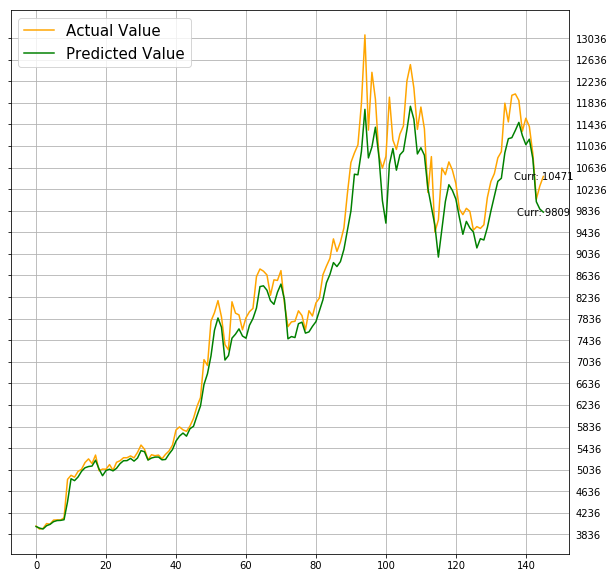

In [74]:
def get_model_name():
    minute = time.localtime().tm_min
    hour = time.localtime().tm_hour
    day = time.localtime().tm_mday
    month = time.localtime().tm_mon
    year = time.localtime().tm_year
    name = str(year) + "_" + str(month) + "_" + str(day) + "_"+ str(hour) + "_" + str(minute) + "_price_predictor"
    return name

# used to be main
def train_model():
    
    prepper = DataPrepper()
    trainer = Trainer(DataPrepper=prepper)
    
    

    model = TimeRNN(bat_size=config['batch_size'],
                    in_features=3,
                    h_size=config['lstm_hidden_size'],
                    layer_amnt=config['lstm_num_layers']
                    )

    losses, loss_func, model, min_price, max_price = trainer.train(model=model, 
                                                                   train_data=trainer.train_dataloader,
                                                                   original_prices=prepper.prices,
                                                                   epochs=config['epochs']
                                                                  )
    #trainer.loss_visualize(losses)
    _, _, all_unnormed_outputs = trainer.validation_test(test_dataloader=trainer.test_dataloader,
                                                         criterion=loss_func, 
                                                         model=model, 
                                                         norm_min=min_price, 
                                                         norm_max=max_price
                                                         )
    trainer.prediction_visualization(minimum_price=min_price,
                                     maximum_price=max_price,
                                     close_prices=trainer.y_test,
                                     model_predictions=all_unnormed_outputs)
    
    
    return trainer
    #return prepper.minmax_2,model,min_price,max_price,trainer.y_test,all_unnormed_outputs

      
    
#min_max_scaler,price_model,min_price,max_price,test_values,predictions = train_model()
trainer = train_model()
model_name = get_model_name()

unnormed =  [[ 3992.10571216]
 [ 3935.98040011]
 [ 3948.42488154]
 [ 4038.02915246]
 [ 4027.77722247]
 [ 4103.30511296]
 [ 4107.0294469 ]
 [ 4104.00592849]
 [ 4144.66324069]
 [ 4858.22359844]
 [ 4933.62133747]
 [ 4899.64179607]
 [ 5006.05562799]
 [ 5045.04099458]
 [ 5171.56823212]
 [ 5238.27585862]
 [ 5151.27461679]
 [ 5309.7089841 ]
 [ 5018.49009777]
 [ 5049.16579454]
 [ 5046.37254408]
 [ 5132.55283058]
 [ 5026.07892876]
 [ 5175.0222515 ]
 [ 5204.15615412]
 [ 5259.84095355]
 [ 5260.08123316]
 [ 5293.16973767]
 [ 5257.53827396]
 [ 5358.65594283]
 [ 5494.98458609]
 [ 5416.58335194]
 [ 5221.25605297]
 [ 5315.56579958]
 [ 5297.13435122]
 [ 5308.97813363]
 [ 5239.51730327]
 [ 5322.28361699]
 [ 5384.74630372]
 [ 5494.54407347]
 [ 5774.69007449]
 [ 5831.51620206]
 [ 5777.62348805]
 [ 5749.76106504]
 [ 5848.42587956]
 [ 5989.54009171]
 [ 6211.68860205]
 [ 6376.02984309]
 [ 7079.73873686]
 [ 6970.70185254]
 [ 7795.06114507]
 [ 7952.09388132]
 [ 8174.66288099]
 [ 7871.02954817]
 [ 7359.10382914

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


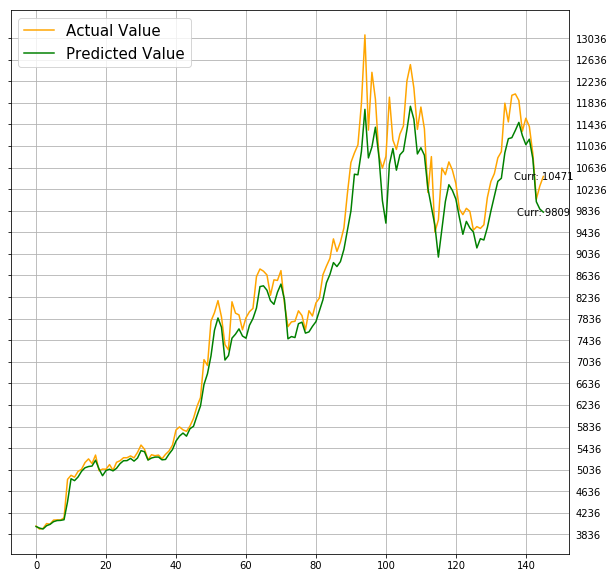

In [75]:
def visualize_model(min_price,max_price,test_set,predicted_set):
    prepper = DataPrepper()
    trainer = Trainer(DataPrepper=prepper)
    trainer.prediction_visualization(minimum_price=min_price,
                                     maximum_price=max_price,
                                     close_prices=trainer.y_test,
                                     model_predictions=predicted_set)
    
visualize_model(min_price=trainer.min_price,max_price=trainer.max_price,test_set=trainer.unnorm_y_test,predicted_set=trainer.unnorm_predictions)

In [76]:
!pip install -q tf-nightly-2.0-preview

     |████████████████████████████████| 88.6MB 1.3MB/s 
     |████████████████████████████████| 450kB 54.0MB/s 
     |████████████████████████████████| 4.1MB 44.1MB/s 
     |████████████████████████████████| 71kB 28.4MB/s 


In [0]:
# %load_ext tensorboard
# %tensorboard --logdir /content/gdrive/My\ Drive/College/Undergraduate\ Research/StockData/tensorboard_logs/

## Model Inference Testing

tensor(3189.0200, dtype=torch.float64)
tensor(19102.6600, dtype=torch.float64)
BTC prediction:  [tensor([[7089.3779]], device='cuda:0')]
[7089.3779296875]


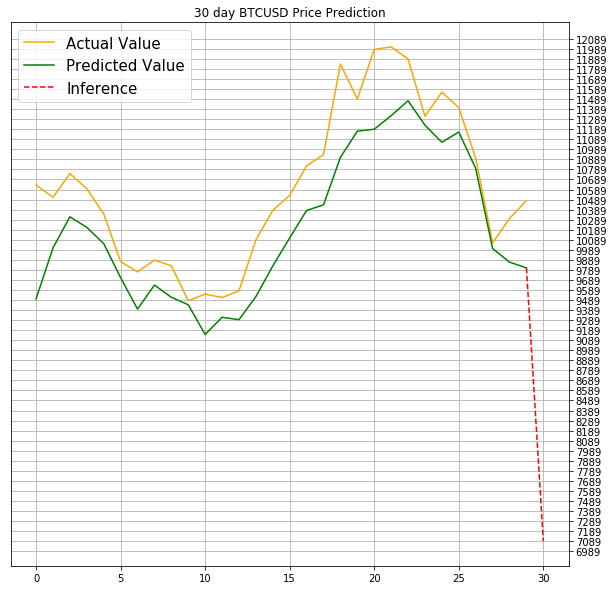

In [77]:
class Inferencer(object):
    def __init__(self):
        pass
    def un_normalize(self,norm_val,min_val,max_val,typelist=None):
        if(typelist):
            for idx,item in enumerate(norm_val):
                new_val = item * (max_val - min_val) + min_val
                norm_val[idx] = new_val
            return norm_val
        else:
            return norm_val * (max_val - min_val) + min_val 

    def inference(self,value, normalize_method, model,minimum_price,maximum_price):
        value = np.array(value)
        predictions = []
        for sample in value:
            sample = np.array(sample).reshape(1,-1)
            example = torch.tensor(normalize_method.transform(sample)).float()
            
            if(str(device) == 'cuda'):
                example = example.to(device)

            output = model(example)
            output_unnorm = self.un_normalize(norm_val=output.detach(),min_val=minimum_price,max_val=maximum_price)
            predictions.append(output_unnorm)
        return predictions
    
    def prediction_visualize(self,save=False,window=0,test_vals=[],pred_values=[],inference_values=[]):

        if(window == 0):
            plt.close()
            # --- visualize ---
            f,arr = plt.subplots(figsize=(10,10))
            arr.plot(test_vals,'#FFA500')
            arr.plot(pred_values,'g')

            x_val = np.arange(len(pred_values),len(pred_values)+len(inference_values),1)
            # -- Connect --
            x = [x_val[0] - 1, x_val[0]]
            y = [pred_values[-1],inference_values[0]]
            arr.plot(x,y,'r')
            
            arr.plot(x_val,inference_values,'r')
            arr.grid()
            if(save):
                plt.savefig('/content/gdrive/My Drive/College/Undergraduate Research/StockData/images/current.png')
        else:
            plt.close()
            test_vals = test_vals[-window:]
            pred_vals = pred_values[-window:]

            f,arr = plt.subplots(figsize=(10,10))
            arr.plot(test_vals,'#FFA500')
            arr.plot(pred_vals,'g')

            x_val = np.arange(len(pred_vals),len(pred_vals)+len(inference_values),1)
            # -- Connect --
            x = [x_val[0] - 1, x_val[0]]
            y = [pred_values[-1],inference_values[0]]
            arr.plot(x,y,'r--')

            arr.plot(x_val,inference_values,'r--')
            arr.grid()

            start = min( np.min(test_vals),np.min(pred_vals),np.min(inference_values))
            end = max(( np.max(test_vals),np.max(pred_vals),np.max(inference_values)))

            plt.yticks(np.arange(start-100,end+100,100))
            arr.yaxis.tick_right()
            arr.set_title(str(window) + ' day BTCUSD Price Prediction')
            arr.legend(['Actual Value','Predicted Value','Inference'],prop={'size': 15})

            #fig_size[0] = 10
            #fig_size[1] = 10
            #plt.rcParams["figure.figsize"] = fig_size
            if(save):
                plt.savefig('/content/gdrive/My Drive/College/Undergraduate Research/StockData/images/current.png')

            
def main(normalizer,model,minimum_price,maximum_price,test_vals,predicted_vals):
    inf = Inferencer()
    print(minimum_price)
    print(maximum_price)
    output = inf.inference(value=[[10000,10500,vol[-1]]
                                  ],
                       normalize_method=normalizer,
                       model=model,
                       minimum_price=minimum_price,
                       maximum_price=maximum_price
                      )
    print('BTC prediction: ', output)

    for idx,out in enumerate(output):
        output[idx] = np.asscalar(out.cpu())
    print(output)

    inf.prediction_visualize(save=True,window=30,
                             test_vals=test_vals,
                             pred_values=predicted_vals,
                             inference_values=output
                             )
    

    
main(normalizer=trainer.dataprepper.min_max_scaler,
     model=trainer.model,
     minimum_price=trainer.min_price,
     maximum_price=trainer.max_price,
     test_vals=trainer.unnorm_y_test,
     predicted_vals=trainer.unnorm_predictions)



In [0]:
# 